# Analyzing Time Series Data

## Intialization

### Import Libraries

In [1]:
import numpy as np # to work with arrays and perform operations on it
import pandas as pd # to work with dataframes and perform operations on it

import matplotlib.pyplot as plt # to plot graphs
import scipy.stats as stats # to perform statistical operations
import scipy.stats as norm # to perform normality tests
import statsmodels.api as sm # to perform statistical operations specifically on linear regression
from  statsmodels.tsa.stattools import acf # to perform statistical operations specifically on time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # to plot ACF and PACF plots
from statsmodels.tsa.stattools import adfuller # to perform dickey fuller test for stationarity of time series
from statsmodels.tsa.arima_process import ArmaProcess # to generate ARMA processes
from statsmodels.tsa.arima.model import ARIMA # to perform ARIMA modelling
from statsmodels.graphics.tsaplots import plot_predict # to plot the prediction of ARIMA model

import seaborn as sns # to plot graphs
from datetime import datetime, timedelta # to work with datetime and perform operations on it 
import time # to work with time 

import swifter # to apply functions on pandas dataframe in parallel
import zipfile # to work with zip files

# system related packages
import os
import sys
from pathlib import Path

# custom functions
import basic.basic_functions as bf

import warnings # to ignore warnings
warnings.filterwarnings('ignore')

### Connect to Drive

In [3]:
base_folder,data,archive,output = bf.set_folders()

Not Running on Colab and no project specified
Base Folder is C:\Users\abdul\OneDrive\Documents\MSBA
Data Folder is C:\Users\abdul\OneDrive\Documents\MSBA\data_sets
Archive Folder is C:\Users\abdul\OneDrive\Documents\MSBA\archive
Output Folder is C:\Users\abdul\OneDrive\Documents\MSBA\output
The path to the custom functions is C:/Users/abdul/OneDrive/Documents/MSBA/custom_functions
The working directory is c:\Users\abdul\OneDrive\Documents\MSBA\notebooks\Time_Series_Analysis


In [4]:
# This code block is to set the default style for the plots and pandas

# set the default style for the plots
plt.style.use('ggplot')
# set the default size of the plots
plt.rcParams['figure.figsize'] = (16, 9)
# set the default font size for the plots
plt.rcParams['font.size'] = 14
# set the default style for the plots
plt.rcParams['lines.linewidth'] = 2
# set the default marker size for the plots
plt.rcParams['lines.markersize'] = 10

pd.options.display.max_columns = 100 # to display all the columns of the dataframe
pd.options.display.float_format =  '{:.2f}'.format # to display all the float values in 2 decimal places

In [5]:
bf.download_file('https://assets.datacamp.com/production/repositories/1120/datasets/850e5614f8de4b134f40b4eeca27c7d0b91aeed2/NOAA_TAVG.csv', data/'NOAA_TAVG.csv')

Downloaded file saved to C:\Users\abdul\OneDrive\Documents\MSBA\data_sets\NOAA_TAVG.csv


### Unzip data files

In [6]:
zips = [x for x in archive.iterdir() if 'zip' in x.name]
for entry in archive.iterdir():
  if 'zip' in entry.name:
    print(entry.name)

Ad A_B Tetsing.zip
air_quality_data.zip
data.zip
ml-latest-small.zip
my_spotify_data.zip
my_spotify_data_2.zip
SMS_spam.zip
Spotify-20230303T164824Z-001.zip
stock_data.zip


#### Ozone Data

In [7]:
file = zips[1]

with zipfile.ZipFile(file,'r') as f:
  print(f.namelist())
  f.extractall(data)
  print('\n',f'Data was extracted to {data}')

['co_cities.csv', 'nyc.csv', 'ozone_nyc.csv', 'ozone_nyla.csv']

 Data was extracted to C:\Users\abdul\OneDrive\Documents\MSBA\data_sets


#### Stocks Data

In [8]:
file = zips[-1]

with zipfile.ZipFile(file,'r') as f:
  print(f.namelist())
  f.extractall(data)
  print('\n',f'Data was extracted to {data}')

['5_stocks.csv', 'apple_google.csv', 'asset_classes.csv', 'components.csv', 'debt_unemployment.csv', 'djia.csv', 'djia2.csv', 'dow_jones.csv', 'fb.csv', 'gdp_growth.csv', 'goog_fb.csv', 'google.csv', 'index.csv', 'listings.xlsx', 'market_cap_series.csv', 'msft_aapl.csv', 'nyse.csv', 'random_walk.csv', 'sp500.csv', 'stock_data.csv', 'stocks_4.csv', 'tickers.csv', 'unrate.csv', 'unrate_2000.csv', 'yahoo.csv']

 Data was extracted to C:\Users\abdul\OneDrive\Documents\MSBA\data_sets


## Time series Analysis: Solving Problems

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6317 entries, 1999-07-01 to 2017-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ozone   6317 non-null   float64
 1   pm25    6317 non-null   float64
 2   co      6317 non-null   float64
dtypes: float64(3)
memory usage: 197.4 KB
None


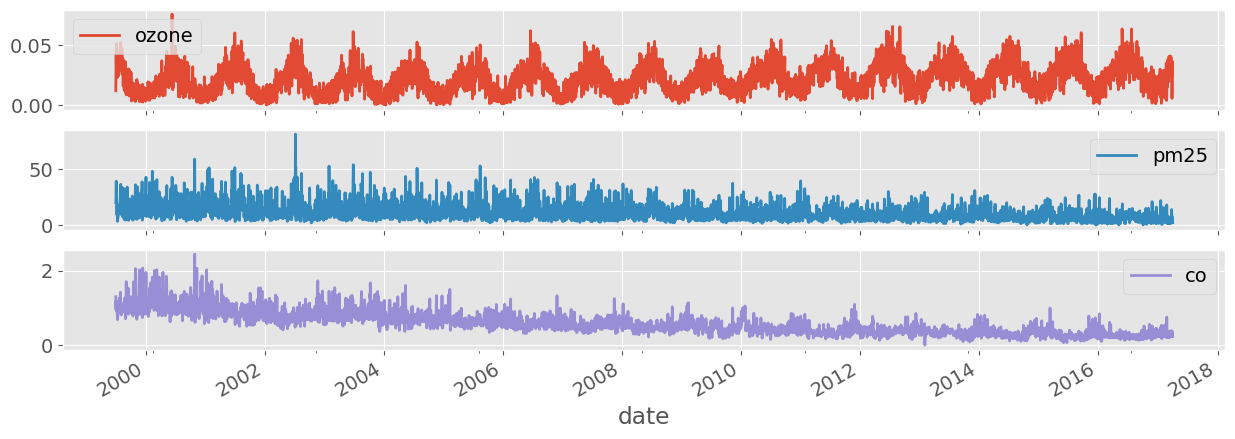

In [9]:
# Read data from csv file
# In the case of date column we need to parse it as a date
# We also need to set the date column as the index ideally when we are performing time series analysis
nyc_df = pd.read_csv(data/'nyc.csv',parse_dates=['date'],index_col='date')
print(nyc_df.info())

# Plot the data
nyc_df.plot(subplots= True, figsize=(15,5))
plt.show()

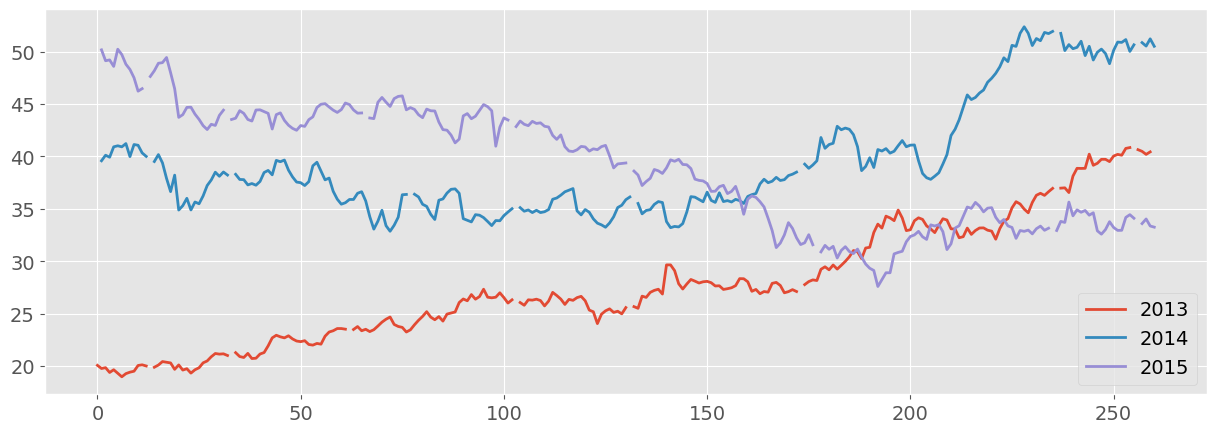

In [10]:
# import yahoo data
yahoo = pd.read_csv(data/'yahoo.csv',parse_dates=['date'],index_col='date')

# Create dataframe prices here
prices = pd.DataFrame()

# Select data for each year and concatenate with prices here 
for year in ['2013', '2014', '2015']:
    price_per_year = yahoo.loc[year, ['price']].reset_index(drop=True)
    price_per_year.rename(columns={'price': year}, inplace=True)
    prices = pd.concat([prices, price_per_year], axis=1)

# Plot prices
prices.plot(figsize=(15,5))
plt.show()


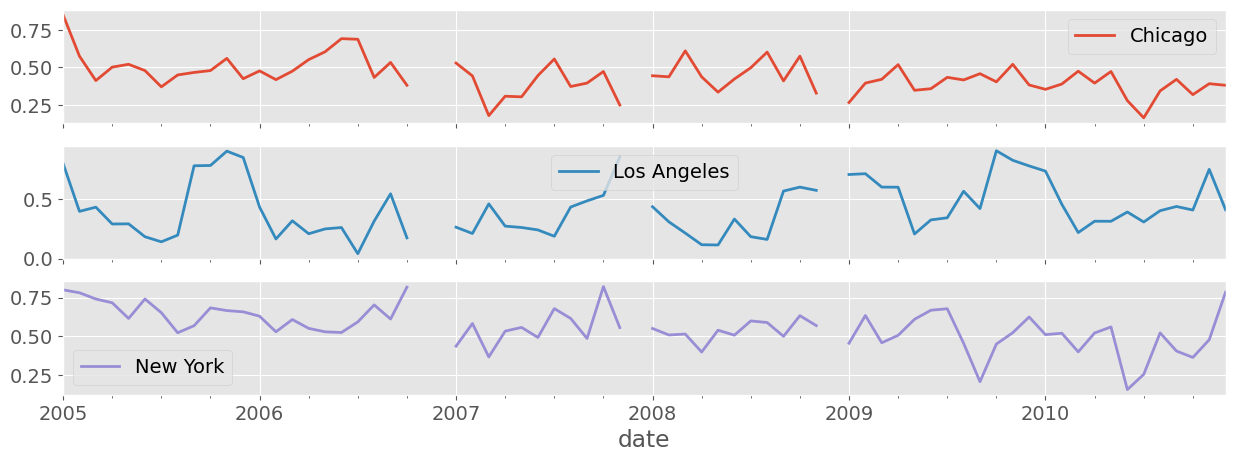

In [11]:
# Load co_cities dataset
co_cities = pd.read_csv(data/'co_cities.csv',parse_dates=['date'],index_col='date')

# Use different frequency for each city
co_cities = co_cities.asfreq('M')
co_cities.plot(subplots=True, figsize=(15, 5))
plt.show()

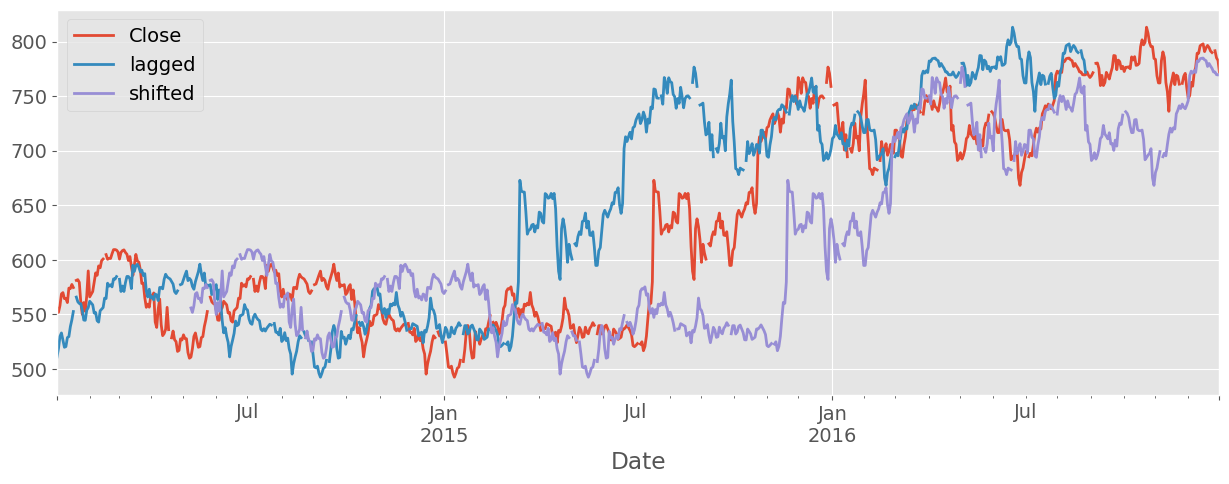

In [12]:
# Shift is an inbuilt function in pandas
# It shifts the data by the number of periods specified
# It is a time series function

# Import data here
google = pd.read_csv(data/'google.csv', parse_dates=['Date'], index_col='Date')

# Set data frequency to business daily
google = google.asfreq('B')

# Create 'lagged' and 'shifted'
google['lagged'] = google.Close.shift(-90)
google['shifted'] = google.Close.shift(90)

# Plot the google price series
google.plot(figsize=(15, 5))
plt.show()

Close  shifted_return  difference  daily_return
Date                                                       
2014-02-12 592.75             NaN         NaN           NaN
2014-02-13 599.35          556.00       43.35         43.35
2014-02-14 600.80          551.95       48.85         48.85
2014-02-17    NaN          558.10         NaN           NaN
2014-02-18 604.83          568.86       35.97         35.97
2014-02-19 600.57          570.04       30.53         30.53
2014-02-20 601.45          564.55       36.90         36.90
2014-02-21 601.29          564.52       36.77         36.77
2014-02-24 605.65          560.93       44.72         44.72
2014-02-25 609.39          574.13       35.26         35.26
2014-02-26 609.47          573.74       35.73         35.73

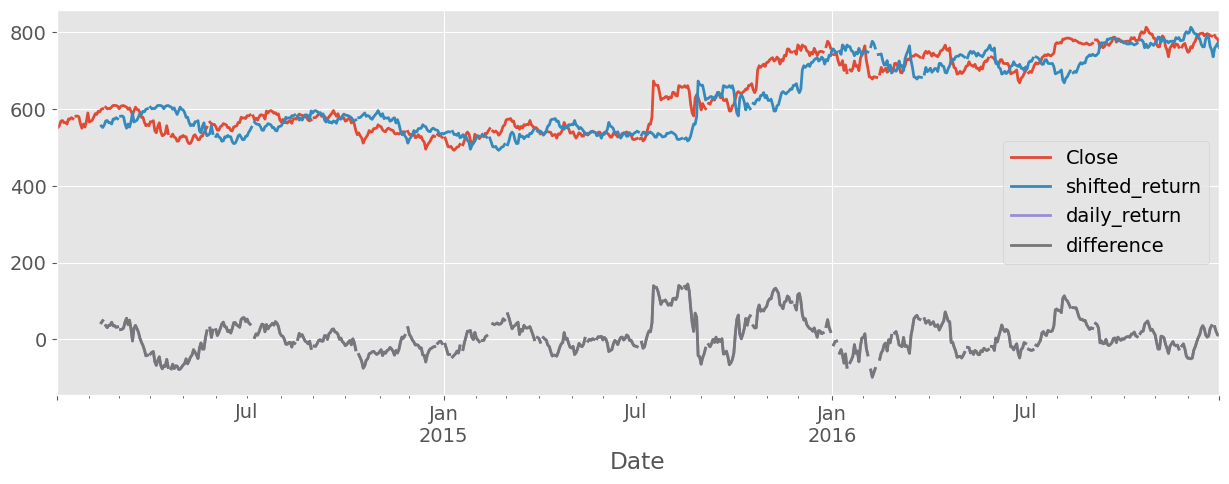

In [13]:
# Another use of the shift function is to calculate the percentage change in the data
# This is a very common operation in time series analysis
# We can use the shift function to calculate the percentage change in the data

# Import data here
google = pd.read_csv(data/'google.csv', parse_dates=['Date'], index_col='Date')

# Set data frequency to business daily
google = google.asfreq('B')

# Create shifted_return
google['shifted_return'] = google.Close.shift(30)

# Create daily_return
google['daily_return'] = google.Close - google.shifted_return

# The diff() function is used to calculate the difference between the current value and the previous value
# same as the manual calculation we did above
google['difference'] = google.Close.diff(30)
display(google[['Close','shifted_return','difference','daily_return']][29:40])

# Plot the google price series
google.plot(figsize=(15,5))
plt.show()


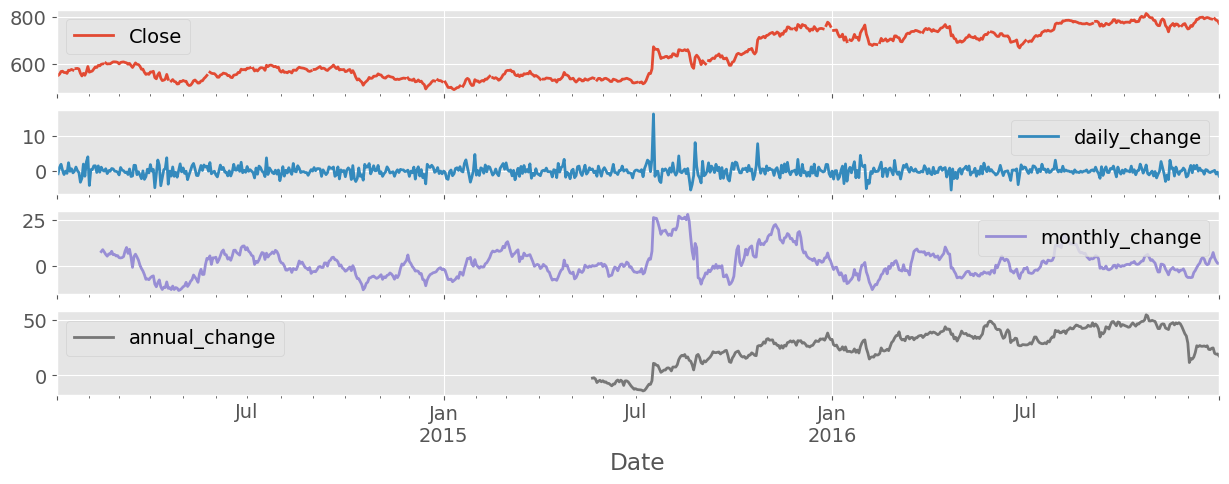

In [14]:
# Another useful function in pandas is pct_change()
# It calculates the percentage change in the data

# Import data here
google = pd.read_csv(data/'google.csv', parse_dates=['Date'], index_col='Date')

# Set data frequency to business daily
google = google.asfreq('B')

# # Create pct_change
google['daily_change'] = google.Close.pct_change(1) * 100
google['monthly_change'] = google.Close.pct_change(30) * 100
google['annual_change'] = google.Close.pct_change(360) * 100

# # Plot google price series
google.plot(subplots=True, figsize=(15, 5))
plt.show()



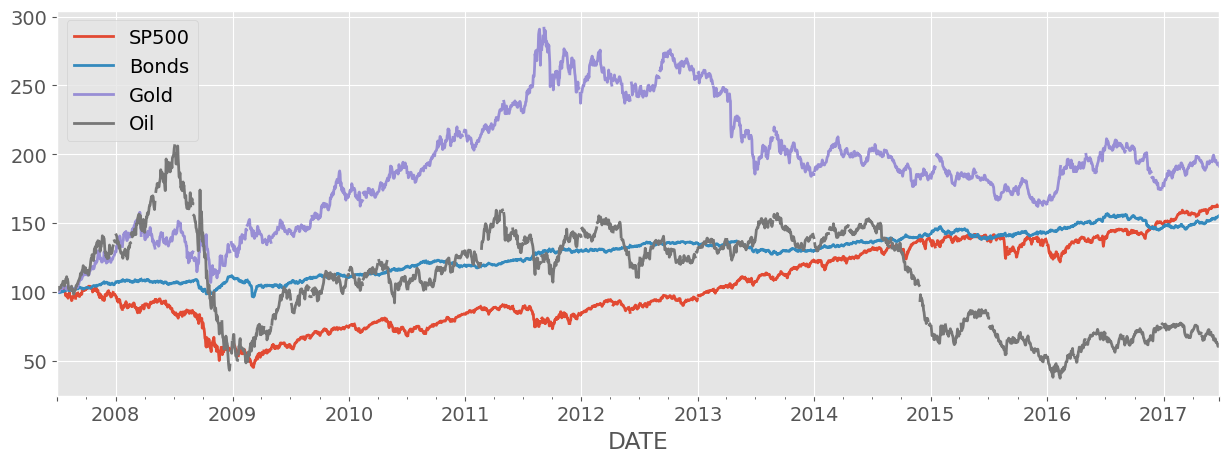

In [15]:
# Another useful concept to understand is the concept of normalization
# Normalization is the process of converting the data to a common scale
# This is done to make the data comparable
# Normalization is done by dividing the data by the first value in the series
# This is called the normalization constant
# The normalized data is then multiplied by 100 to convert it to a percentage

# Import data here
prices = pd.read_csv(data/'asset_classes.csv', parse_dates=['DATE'], index_col='DATE')

# Set data frequency to business daily
prices = prices.asfreq('B')

# Calculate the normalization constant
normalization_constant = prices.iloc[0]

# Normalize the data
# Intersetingly the pandas library has a div() function which is used to divide the data by a constant
# Similarly it has a mul() function which is used to multiply the data by a constant
# There are math functions like add(), sub() etc which can be used to perform mathematical operations on the data
normalized = prices.div(normalization_constant).mul(100)

# Plot the normalized data
normalized.plot(figsize=(15, 5))
plt.show()

# This makes it easier to compare the data
# We can see that the data is now comparable


In [16]:
# When use asfreq() function to resample the data we typically end up with missing values

# Import data here
google = pd.read_csv(data/'google.csv', parse_dates=['Date'], index_col='Date')

# Set data frequency to business daily
google = google.asfreq('M'); display(google.head())
print('\n')
google = google.asfreq('B'); display(google.head())

# An example of a forward fill is shown below along with reindexing
# Set start and end dates
start = '2016-1-1'
end = '2016-2-29'

# Create monthly_dates here
monthly_dates = pd.date_range(start, end, freq='M')

# Create and print monthly here
monthly = pd.Series(data=[1,2], index=monthly_dates)
print(monthly,'\n')

# Create weekly_dates here
weekly_dates = pd.date_range(start, end, freq='W')
# Print monthly, reindexed using weekly_dates
print(monthly.reindex(weekly_dates, method='bfill'))



Close
Date             
2014-01-31 589.89
2014-02-28 607.22
2014-03-31 556.70
2014-04-30 526.66
2014-05-31    NaN

Close
Date             
2014-01-31 589.89
2014-02-03    NaN
2014-02-04    NaN
2014-02-05    NaN
2014-02-06    NaN

2016-01-31    1
2016-02-29    2
Freq: M, dtype: int64 

2016-01-03    1
2016-01-10    1
2016-01-17    1
2016-01-24    1
2016-01-31    1
2016-02-07    2
2016-02-14    2
2016-02-21    2
2016-02-28    2
Freq: W-SUN, dtype: int64


In [17]:
# Another important concept is interpolation and extrapolation
# Interpolation is the process of estimating the value of a missing data point
# Extrapolation is the process of estimating the value of a data point outside the range of the data
# We can use the interpolate() function to perform interpolation
# We can use the extrapolate() function to perform extrapolation

# Import data here
google = pd.read_csv(data/'google.csv', parse_dates=['Date'], index_col='Date')
print(google.head(),'\n')

# Set data frequency to business daily
google = google.asfreq('B')

# Create and print 'google' here
google = google.interpolate()
print(google.head())

#interpolate() function by default uses linear interpolation
# Linear interpolation is the process of drawing a straight line between two points
# We can use the method parameter to specify the type of interpolation

            Close
Date             
2014-01-02 556.00
2014-01-03 551.95
2014-01-04    NaN
2014-01-05    NaN
2014-01-06 558.10 

            Close
Date             
2014-01-02 556.00
2014-01-03 551.95
2014-01-06 558.10
2014-01-07 568.86
2014-01-08 570.04


<Axes: xlabel='date'>

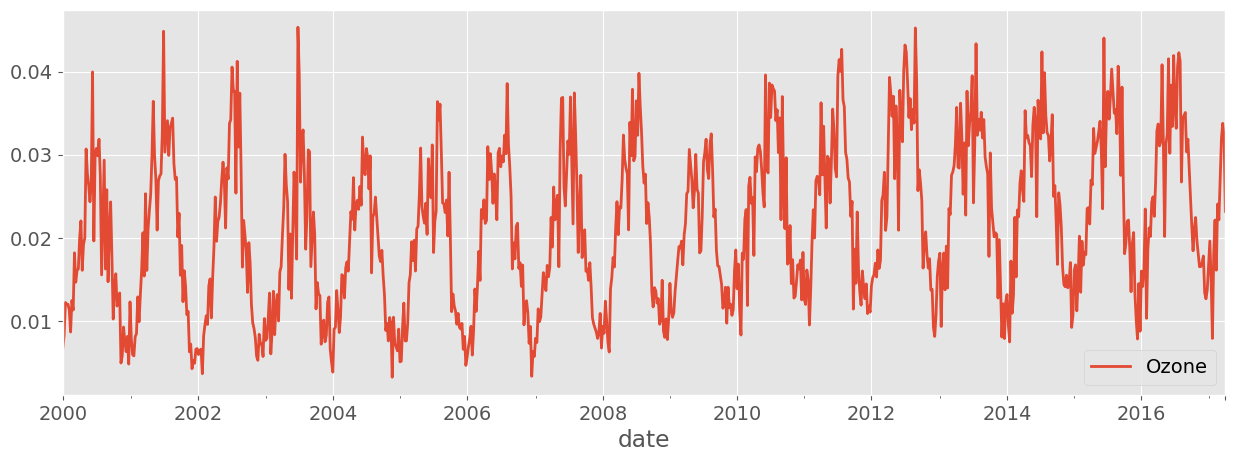

In [18]:
# Downsampling and aggregation
# Downsampling is the process of reducing the frequency of the data
# Aggregation is the process of combining the data to form a summary

# Import data here
ozone = pd.read_csv(data/'ozone_nyc.csv', parse_dates=['date'], index_col='date')

ozone.resample('W').mean().plot(figsize=(15, 5))

# Another function we can use is squeeze()
# This function is used to convert a dataframe to a series
# This is useful when we want to perform operations on the data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6291 entries, 2000-01-01 to 2017-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6167 non-null   float64
dtypes: float64(1)
memory usage: 98.3 KB
None 



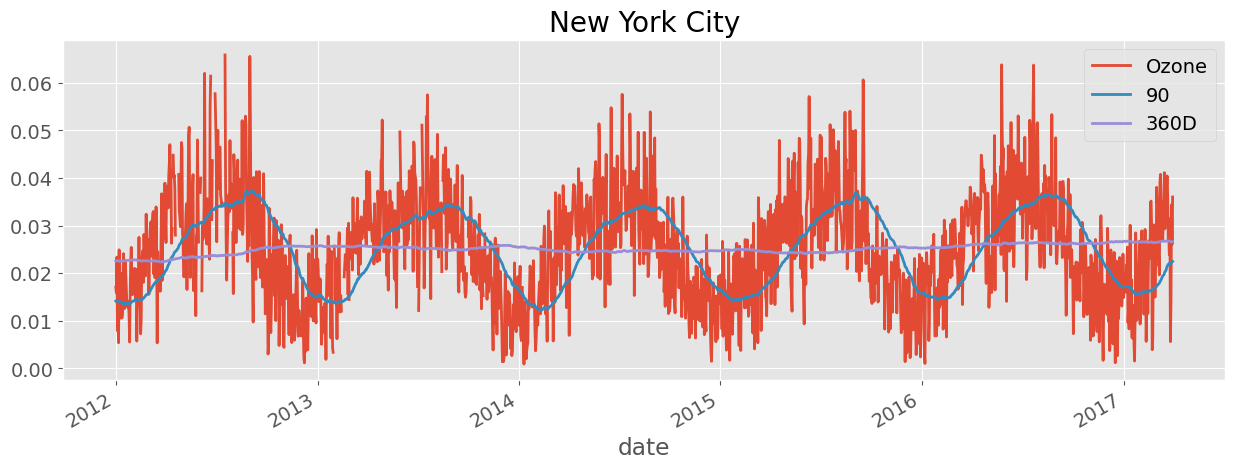

In [19]:
# Finally we can use the rolling() function to calculate the rolling mean
# Rolling mean is the average of the data over a specified period of time

# Import data here
ozone = pd.read_csv(data/'ozone_nyc.csv', parse_dates=['date'], index_col='date')
print(ozone.info(),'\n')

# Calculate 90d and 360d rolling mean for the last price
ozone['90'] = ozone.Ozone.rolling('90D').mean()
ozone['360D'] = ozone.Ozone.rolling('360D').mean()

# Plot data
ozone.loc['2012':].plot(title='New York City',figsize=(15, 5))
plt.show()


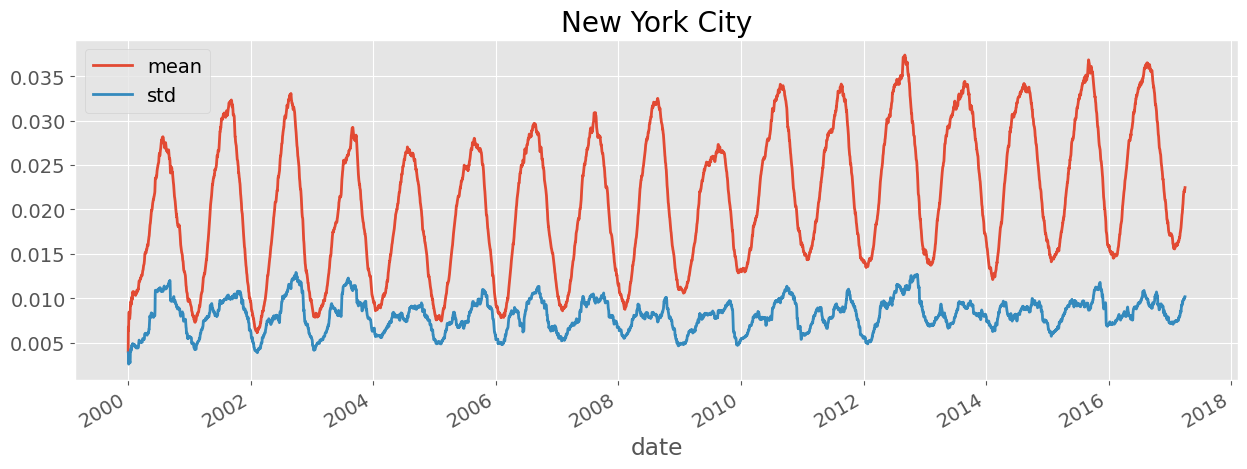

In [20]:
# We can also calculate multiple rolling metrics
# We can use the agg() function to calculate multiple metrics

# Import data here
ozone = pd.read_csv(data/'ozone_nyc.csv', parse_dates=['date'], index_col='date')

# # Calculate 90d rolling mean for the last price
ozone = ozone.Ozone.rolling('90D').agg(['mean','std'])

# Plot data
ozone.plot(title='New York City',figsize=(15, 5))
plt.show()

In [23]:
# We now learn about window functions
# Window functions are used to calculate metrics over a specified period of time
# We will be expanding window functions
# Expanding window functions are used to calculate metrics over a period of time that increases with each new data point

# Import data here
google = pd.read_csv(data/'google.csv', parse_dates=['Date'], index_col='Date').dropna()

# Calculate differences here
differences = google.diff().dropna()

# Select start price here
start_price = google.first('D')

# Calculate cumulative sum 
# cumulative_sum = start_price.append(differences).cumsum()

# Validate cumulative sum equals data
# print(google.equals(cumulative_sum))


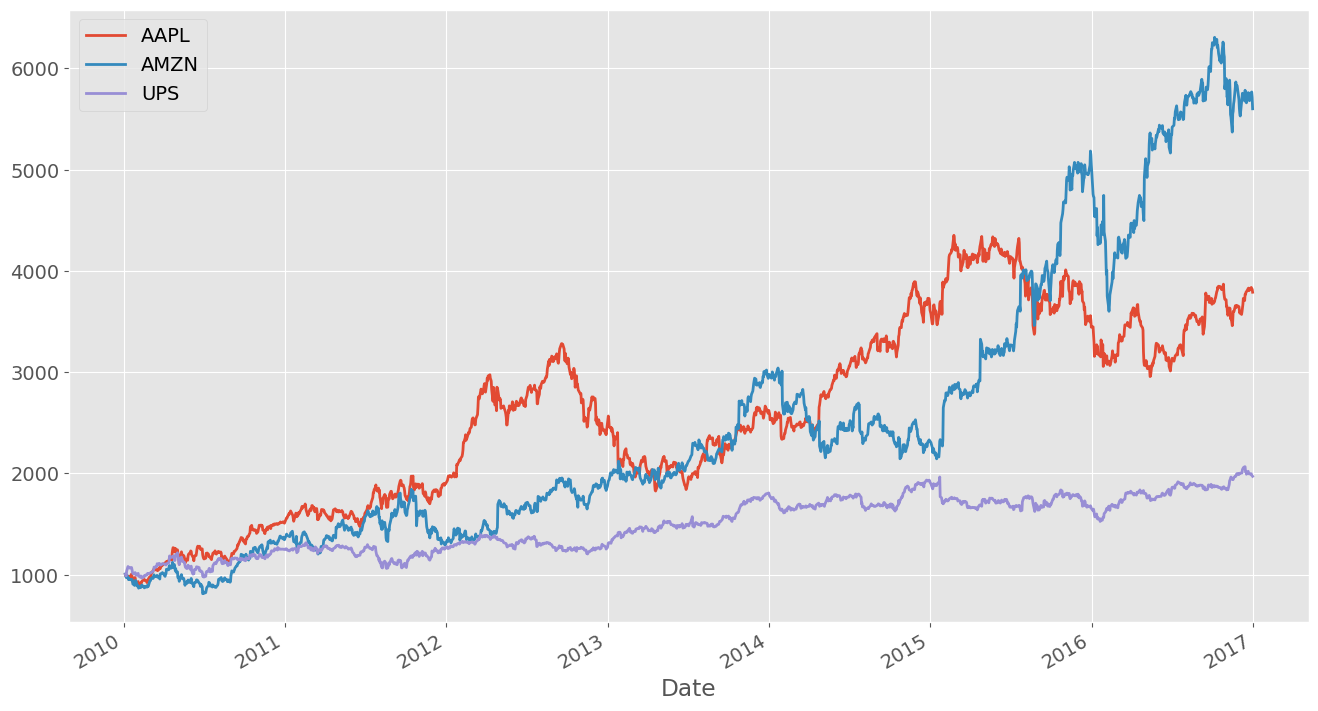

In [24]:
# We can also use the cumprod() function to calculate the cumulative product
# The cumulative product is the product of the data over a specified period of time

# Import data here
stock = pd.read_csv(data/'stock_data.csv', parse_dates=['Date'], index_col='Date').dropna()
stock = stock[['AAPL','AMZN','UPS']]

# Define your investment
investment = 1000

# Calculate the daily returns here
returns = stock.pct_change(1)

# Calculate the cumulative returns here
returns_plus_one = returns + 1
cumulative_return = returns_plus_one.cumprod()

# # Calculate and plot the investment return here 
cumulative_return.mul(investment).plot()
plt.show()

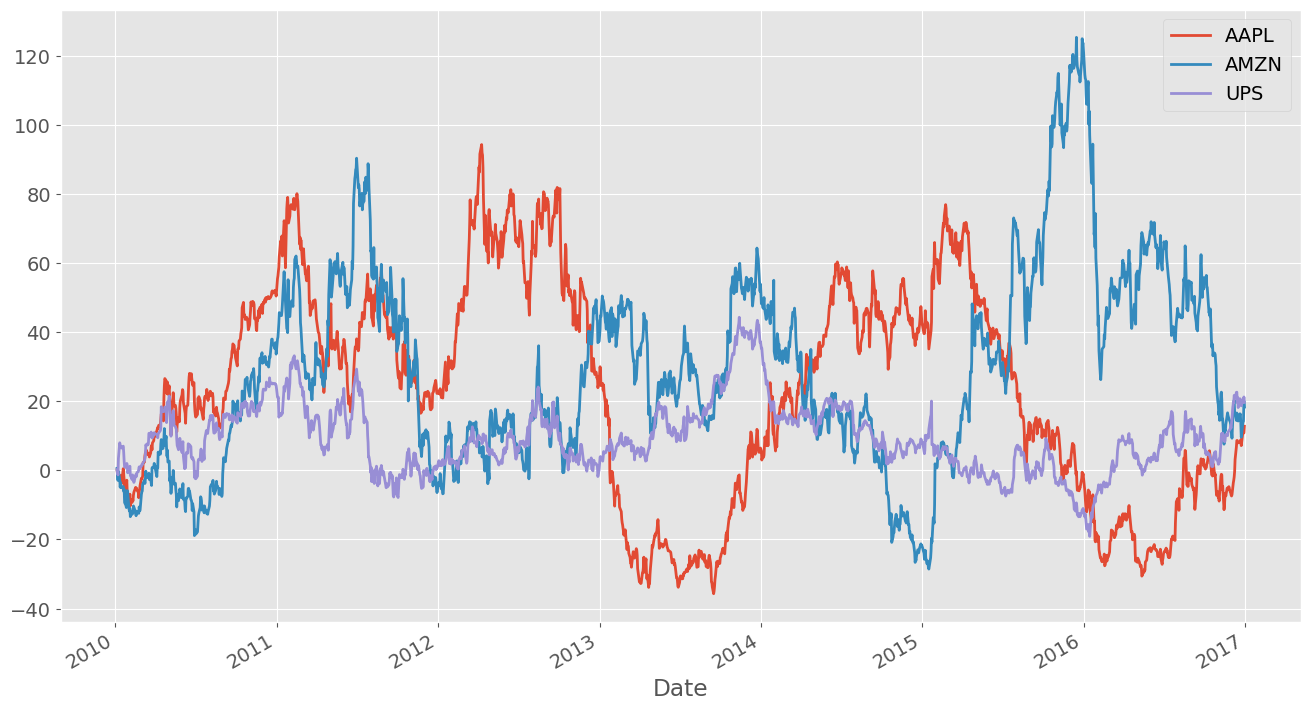

In [25]:
# Define a multi_period_return function
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1
    
# Calculate daily returns
daily_returns = stock.pct_change(1)

# Calculate rolling_annual_returns
rolling_annual_returns = daily_returns.rolling('360D').apply(multi_period_return)

# Plot rolling_annual_returns
rolling_annual_returns.mul(100).plot()
plt.show()

## A Case Study: SP500 Random Walk and Simulations

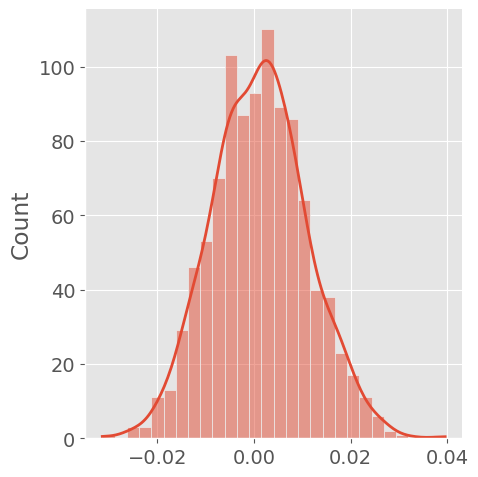

In [26]:
# Set the random seed to 42
np.random.seed(42)

# create a array of random variables normally distributed
# We set a mean of 0.001, a standard deviation 0.01 and size of 1000
# We then plot the distribution of the random variables
random_returns = np.random.normal(loc=0.001, scale=0.01, size=1000)
type(random_returns)
sns.displot(random_returns, kde=True)
plt.show()

In [27]:
# We create a pandas series of the random returns
return_series = pd.Series(random_returns)

# We calculate the cumulative product of the random returns
# We then subtract 1 to get the cumulative returns
# We then multiply by 100 to get the cumulative returns in percentage
random_prices = return_series.add(1).cumprod().sub(1)
random_prices.mul(100)[0:5]

0   0.60
1   0.56
2   1.31
3   2.95
4   2.82
dtype: float64

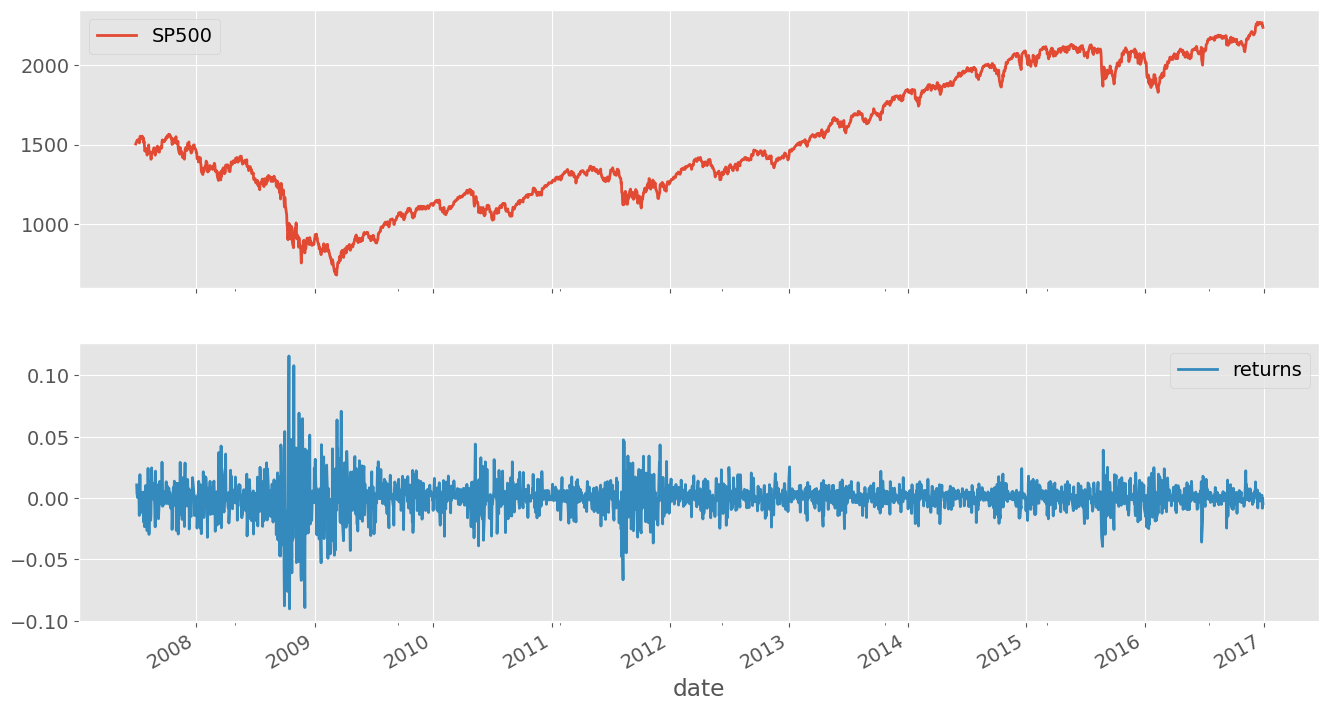

In [28]:
# We can also use the random_walk() function to generate random returns
# We can use the add() function to add 1 to the random returns
# We can use the cumprod() function to calculate the cumulative product
# We can use the sub() function to subtract 1 from the cumulative product
# We can use the mul() function to multiply by 100 to get the cumulative returns in percentage

# Import data here
stock = pd.read_csv(data/'sp500.csv', parse_dates=['date'], index_col='date')

# Calculate daily returns here
stock['returns'] = stock.SP500.pct_change()

stock.plot(subplots=True)
plt.show()

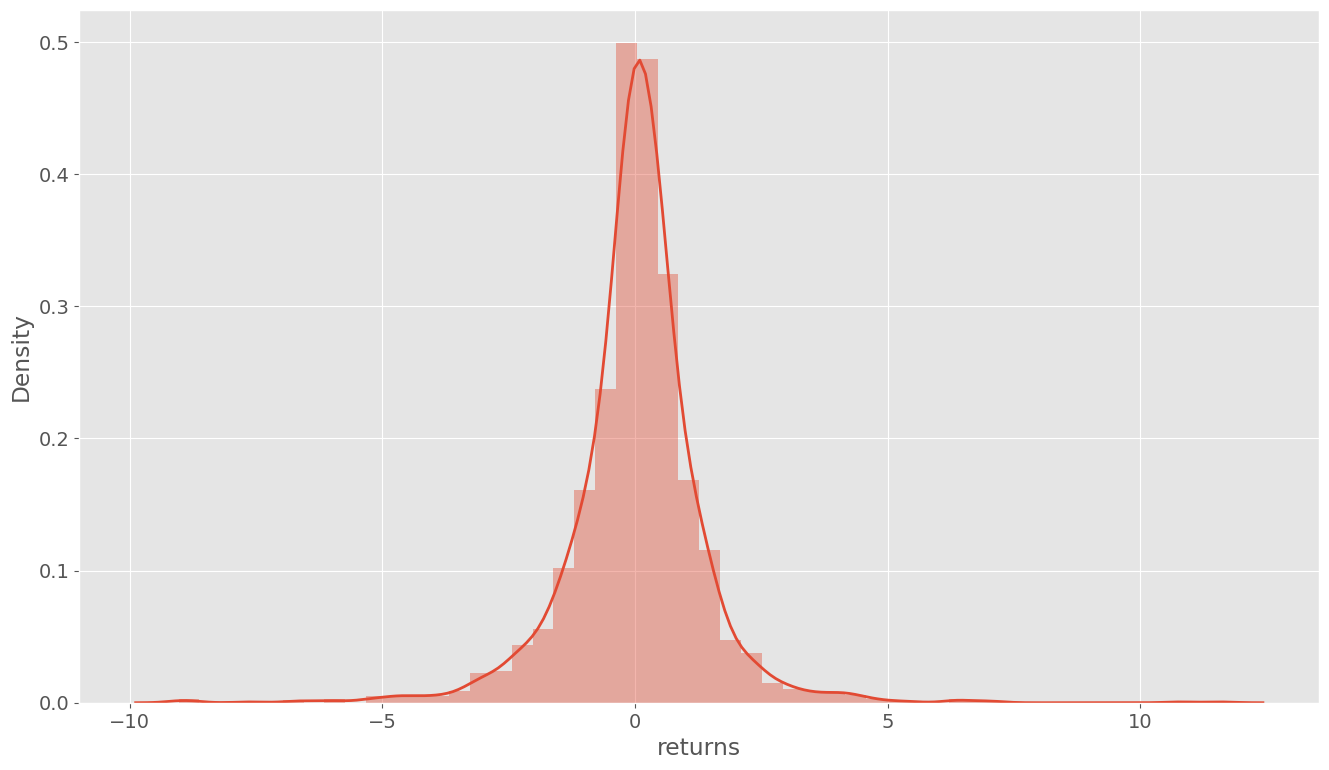

In [29]:
# Plot the distribution of the daily returns
sns.distplot(stock.returns.dropna().mul(100))
plt.show()

### Using a random sample to create a random stock price path

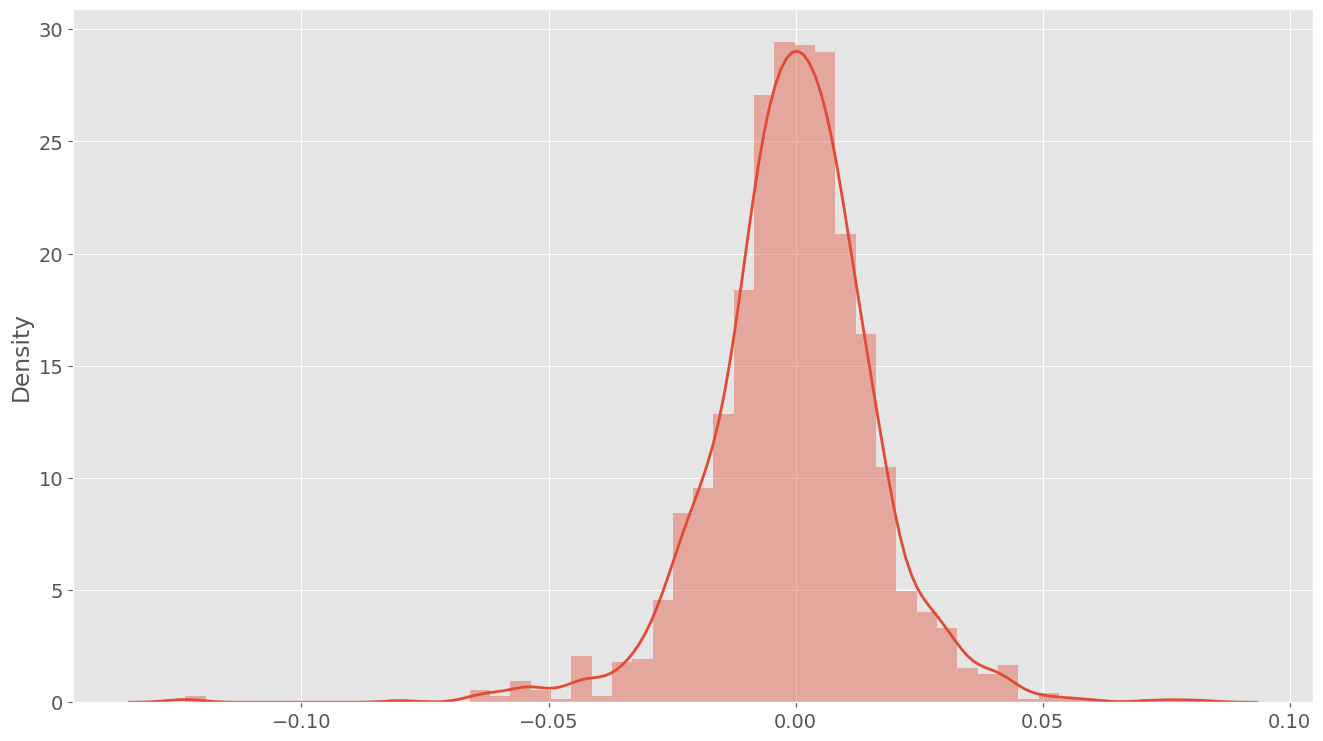

In [30]:
# Set seed here
np.random.seed(42)

stock = pd.read_csv(data/'stock_data.csv', parse_dates=['Date'], index_col='Date')

# Calculate daily_returns here
daily_returns = stock.AAPL.pct_change(1).dropna()

# Get n_obs
n_obs = daily_returns.count()

# Create random_walk 
# We use the random.choice() function to generate random returns
random_walk = np.random.choice(daily_returns, size=n_obs)

# Convert random_walk to pd.series
random_walk = pd.Series(random_walk)

# Plot random_walk distribution
sns.distplot(random_walk)
plt.show()

### Annual return correlations among several stocks

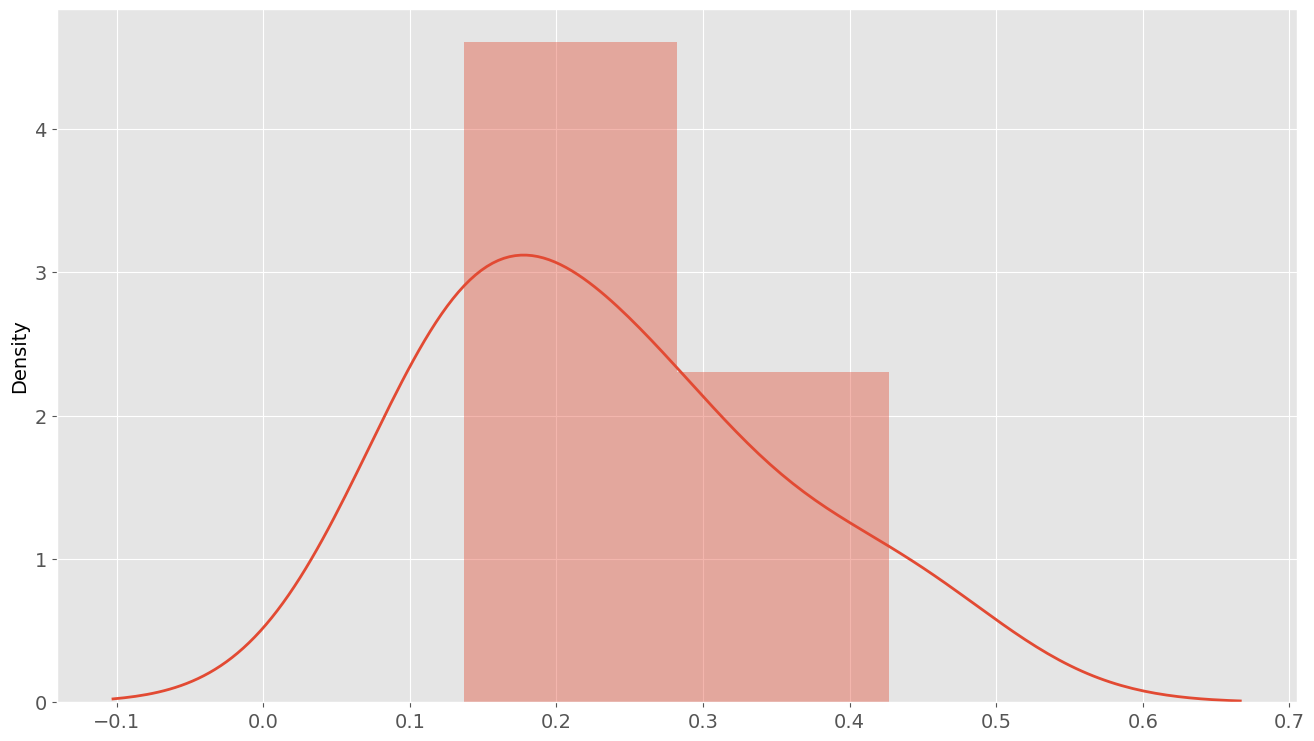

In [30]:
annual_prices = stock.AAPL.resample('A').last()
annual_returns = annual_prices.pct_change().dropna()

# Calculate the mean of the annual returns
mean_return = annual_returns.mean()

# Calculate the standard deviation of the annual returns
std_return = annual_returns.std()

# Set seed here
np.random.seed(42)

# Calculate the number of observations
n_obs = annual_returns.count()

# Create random_walk
random_walk = np.random.normal(loc=mean_return, scale=std_return, size=n_obs)

# Convert random_walk to pd.series
random_walk = pd.Series(random_walk)

# Plot random_walk distribution
sns.distplot(random_walk)
plt.show()

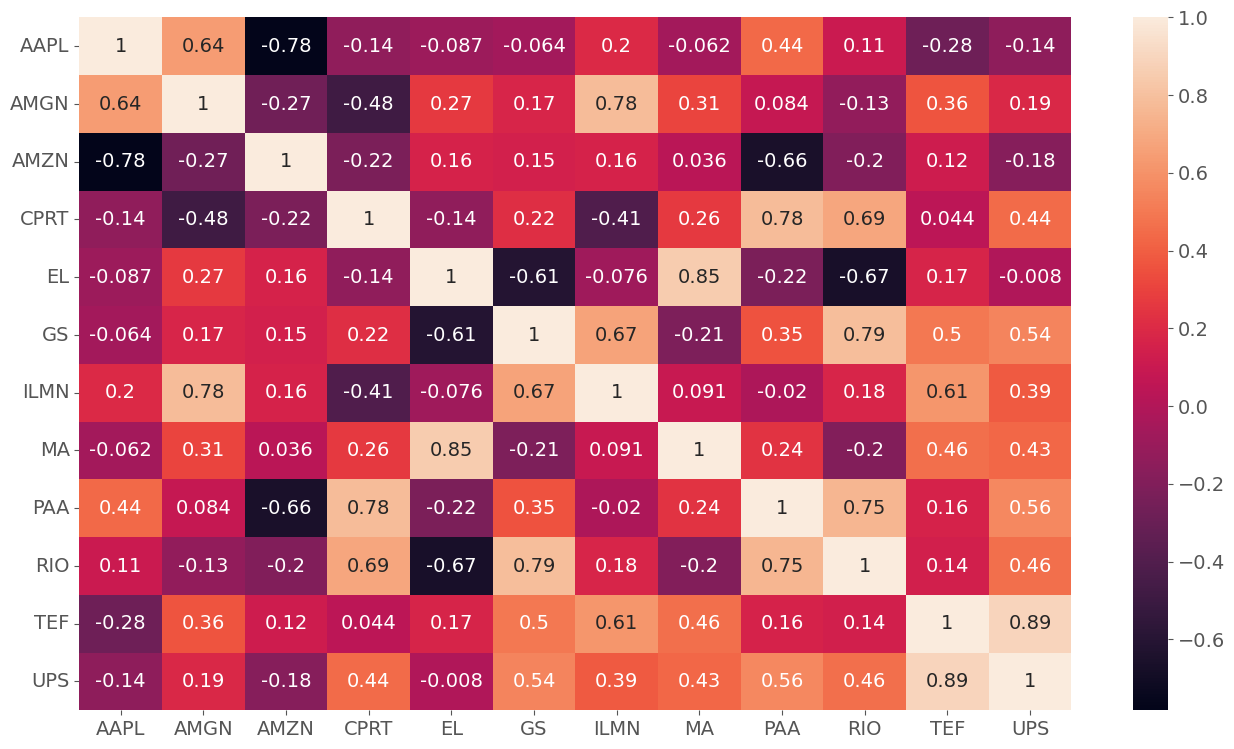

In [31]:
# Creating a Correlation Matrix

annual_prices = stock.resample('A').last()
annual_returns = annual_prices.pct_change()
correlation = annual_returns.corr()

# Plot the correlation matrix
sns.heatmap(correlation, annot=True)
plt.show()


## Selecting index components and import data

An important formula to remember is market risk premium = expected return on the market - risk free rate. Market Capitalization is the total value of a company's outstanding shares. We can use the market capitalization to calculate the market risk premium. 

1. $Market Value = Market Capitalization / Number of Shares$
2. $Share Price * Number of Shares = Market Value$

In [32]:
nyse = pd.read_excel(data/'listings.xlsx', sheet_name='nyse', na_values='n/a').set_index('Stock Symbol')
nyse.dropna(subset=['Sector'],inplace=True)
nyse['Market Capitalization'] /= 1000000

#Selecting index components
components = nyse.groupby('Sector')['Market Capitalization'].nlargest(1)
components.sort_values(ascending=False)

# importing tickers
tickers = components.index.get_level_values(1).tolist()

# Stock Index Component

columns = ['Company Name', 'Market Capitalization', 'Last Sale']
components_info = nyse.loc[tickers, columns]
components_info['Number of Shares'] = components_info['Market Capitalization'] / components_info['Last Sale']
components_info

Company Name  Market Capitalization  \
Stock Symbol                                                          
PG            Procter & Gamble Company (The)              230159.64   
TM                 Toyota Motor Corp Ltd Ord              155660.25   
ABB                                  ABB Ltd               48398.94   
KO                   Coca-Cola Company (The)              183655.31   
WMT                    Wal-Mart Stores, Inc.              221864.61   
XOM                  Exxon Mobil Corporation              338728.71   
JPM                    J P Morgan Chase & Co              300283.25   
JNJ                        Johnson & Johnson              338834.39   
BABA           Alibaba Group Holding Limited              275525.00   
T                                  AT&T Inc.              247339.52   
ORCL                      Oracle Corporation              181046.10   
UPS              United Parcel Service, Inc.               90180.89   

              Last Sale  Number of Shares  
Stock Symbol                               
PG                90.03           2556.48  
TM               104.18           1494.15  
ABB               22.63           2138.71  
KO                42.79           4292.01  
WMT               73.15           3033.01  
XOM               81.69           4146.51  
JPM               84.40           3557.86  
JNJ              124.99           2710.89  
BABA             110.21           2500.00  
T                 40.28           6140.50  
ORCL              44.00           4114.68  
UPS              103.74            869.30

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB


None

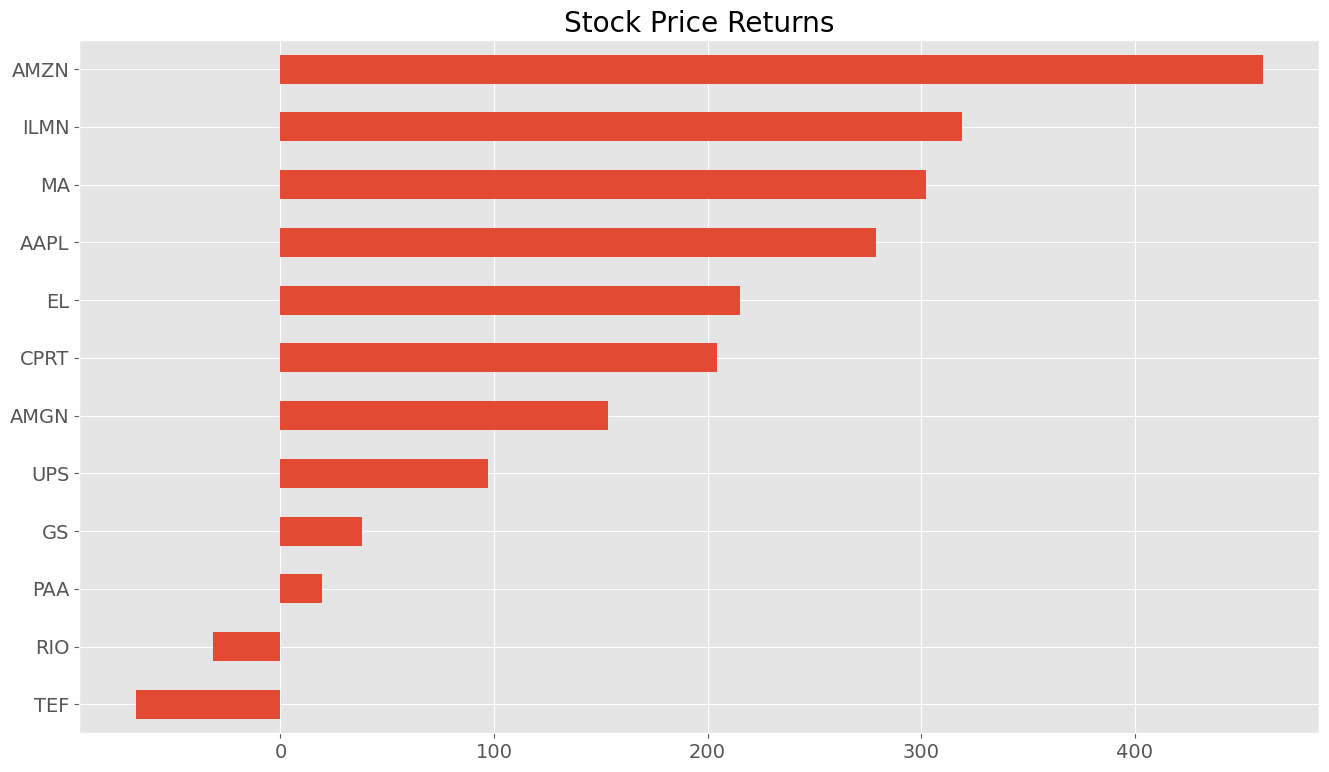

In [35]:
stock_prices = pd.read_csv(data/'stock_data.csv', parse_dates=['Date'], index_col='Date')
display(stock_prices.info())
# Creating a horizontal bar chart represeting the change in stock prices
price_return = stock_prices.iloc[-1].div(stock_prices.iloc[0]).sub(1).mul(100)

# Plot horizontal bar chart of sorted price_return   
price_return.sort_values().plot(kind='barh', title='Stock Price Returns')
plt.show()

### Building a market-cap weighted index

In [36]:
nyse = pd.read_excel(data/'listings.xlsx', sheet_name='nyse', na_values='n/a').set_index('Stock Symbol')
amex = pd.read_excel(data/'listings.xlsx', sheet_name='amex', na_values='n/a').set_index('Stock Symbol')
nasdaq = pd.read_excel(data/'listings.xlsx', sheet_name='nasdaq', na_values='n/a').set_index('Stock Symbol')

nyse['exchange'] = 'NYSE'
amex['exchange'] = 'AMEX'
nasdaq['exchange'] = 'NASDAQ'

# Concatenate the dataframes here
listings = pd.concat([nyse, amex, nasdaq])
tickers = pd.read_csv(data/'tickers.csv', index_col=False,header=None).squeeze().tolist()

# Select components and relevant columns from listings
components = listings.loc[tickers, ['Market Capitalization', 'Last Sale']]

# # Print the first rows of components
print(components.head(),'\n')

# # Calculate the number of shares here
no_shares = components['Market Capitalization'] / components['Last Sale']

# # Print the sorted no_shares
print(no_shares.sort_values(ascending=False))

              Market Capitalization  Last Sale
Stock Symbol                                  
RIO                  70431476895.12      38.94
ILMN                 25409384000.00     173.68
CPRT                 13620922869.40      29.65
EL                   31122510011.04      84.94
AMZN                422138530626.06     884.67 

Stock Symbol
AAPL   5246540000.00
TEF    5037804990.00
RIO    1808717948.00
MA     1108884100.00
UPS     869297154.00
AMGN    735890171.00
PAA     723404994.00
AMZN    477170618.00
CPRT    459390316.00
GS      397817439.00
EL      366405816.00
ILMN    146300000.00
dtype: float64


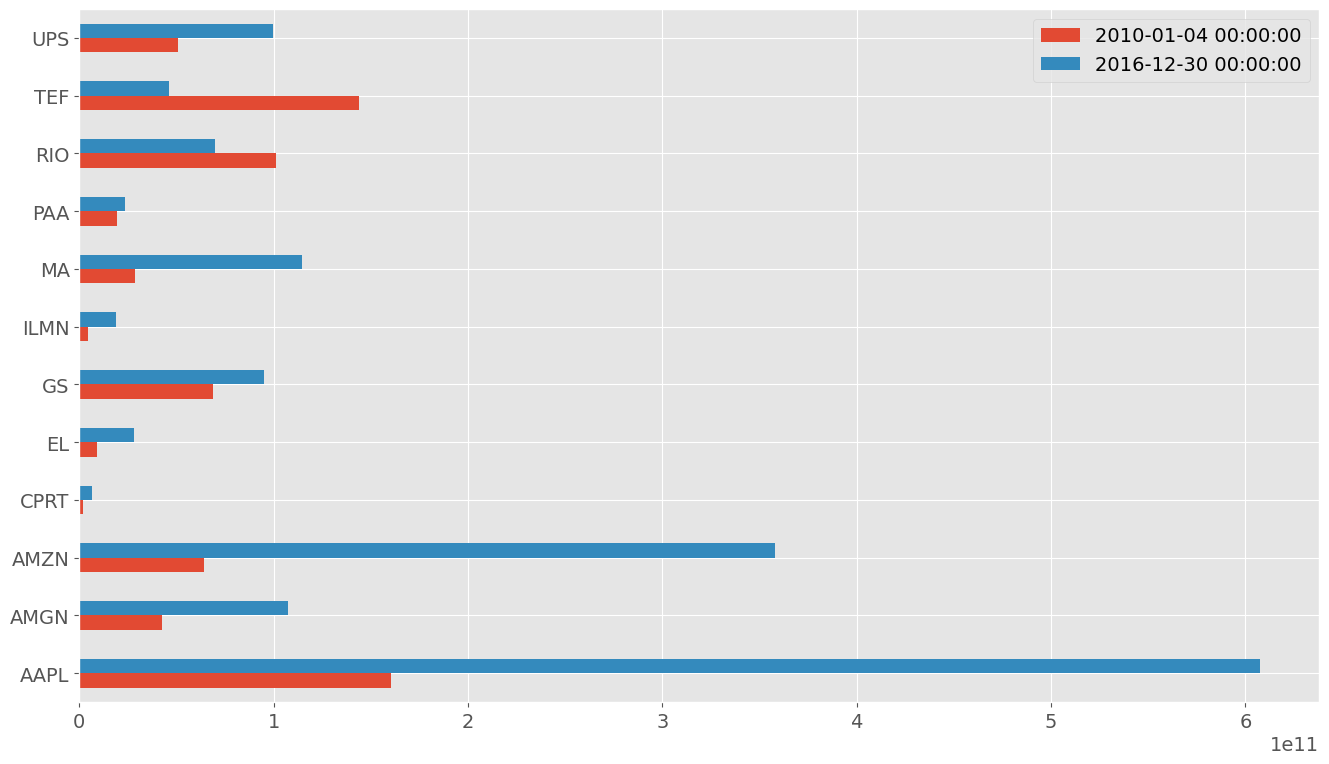

In [37]:
# Calculate the number of shares
no_shares = components['Market Capitalization'] / components['Last Sale']   

# Calculate the market capitalization
market_cap = stock_prices.mul(no_shares, axis=1)

# Select first and last market cap here
first_value = market_cap.iloc[0]
last_value = market_cap.iloc[-1]

# Concatenate and plot first and last market cap here
pd.concat([first_value, last_value],axis=1).plot(kind='barh')
plt.show()


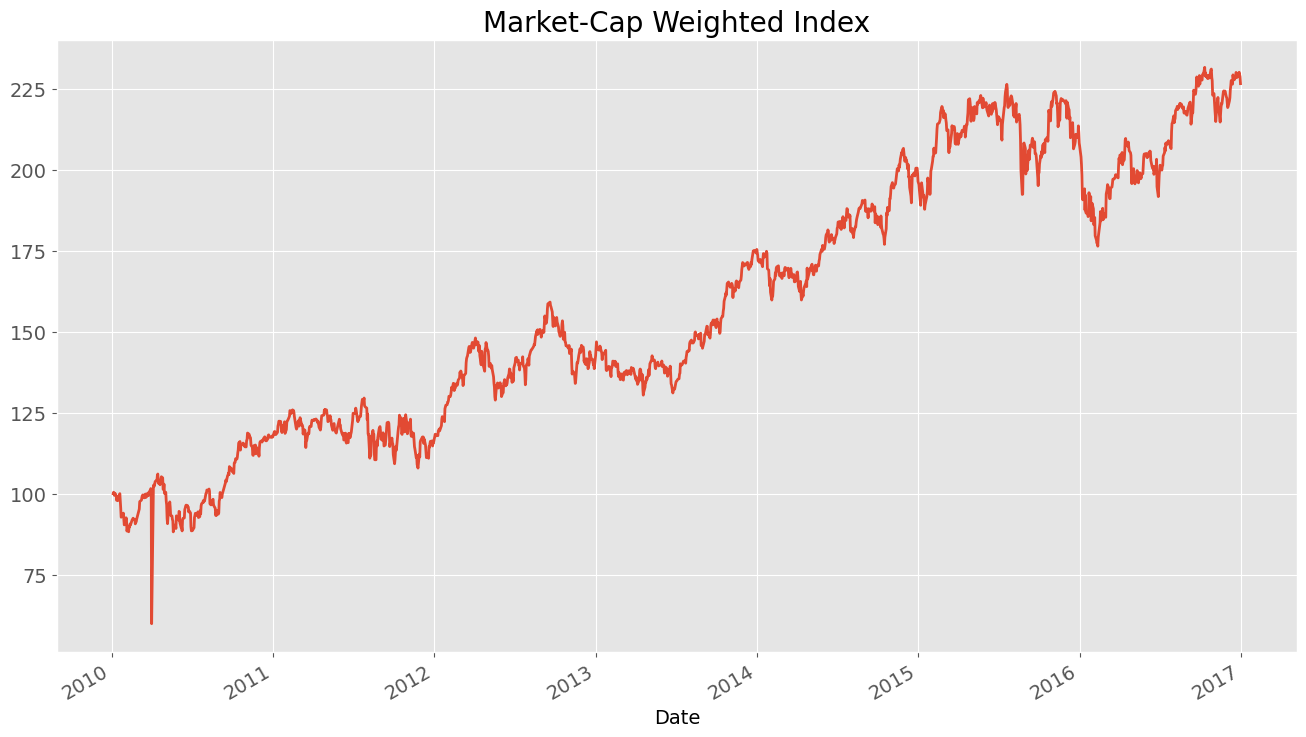

In [38]:
# Ploting a market index change over time
# Import market_cap_series
market_cap_series = pd.read_csv(data/'market_cap_series.csv', index_col='Date', parse_dates=['Date'])

# Aggregate and print the market cap per trading day
raw_index = market_cap_series.sum(axis=1)

# Normalize the aggregate market cap here 
index = raw_index.div(raw_index.iloc[0]).mul(100)

# Plot the index here
index.plot(title='Market-Cap Weighted Index')
plt.show()


<Axes: title={'center': 'Weighted Index Returns'}, ylabel='Stock Symbol'>

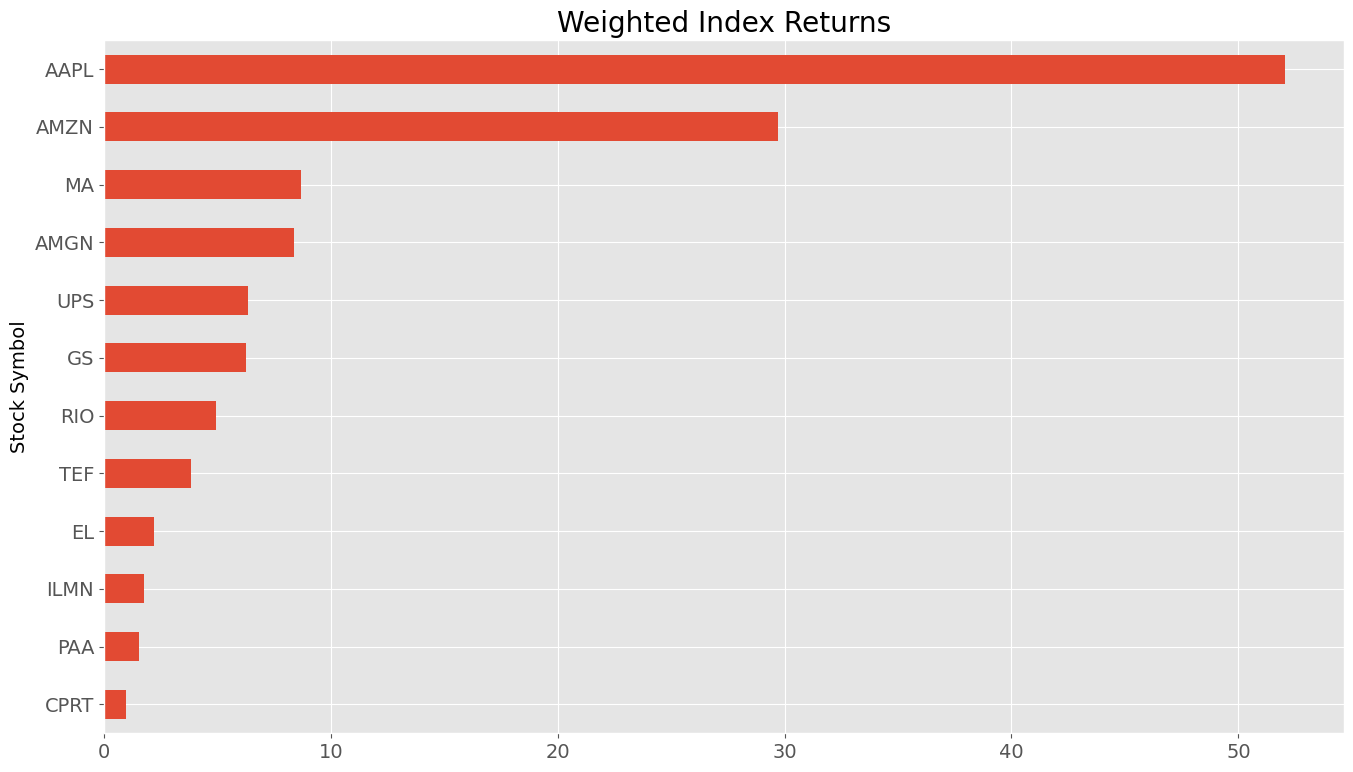

In [39]:
# Calculating the index return
index_return = ((((index.iloc[-1] / index.iloc[0]) - 1)  *100))

# Market Capitalization from components
market_cap = components['Market Capitalization']

# Calculate the weights
weights = market_cap.div(market_cap.sum())

# Calculate the index return
weighted_index_return = weights * index_return
weighted_index_return.sort_values().plot(kind='barh', title='Weighted Index Returns')

            Index   DJIA
Date                    
2010-01-04 100.00 100.00
2010-01-05 100.46  99.89
2010-01-06  99.98  99.90
2010-01-07  99.49 100.22
2010-01-08 100.15 100.32
...           ...    ...
2016-12-23 228.68 188.34
2016-12-27 230.17 188.45
2016-12-28 229.36 187.39
2016-12-29 228.75 187.26
2016-12-30 226.66 186.72

[1762 rows x 2 columns]


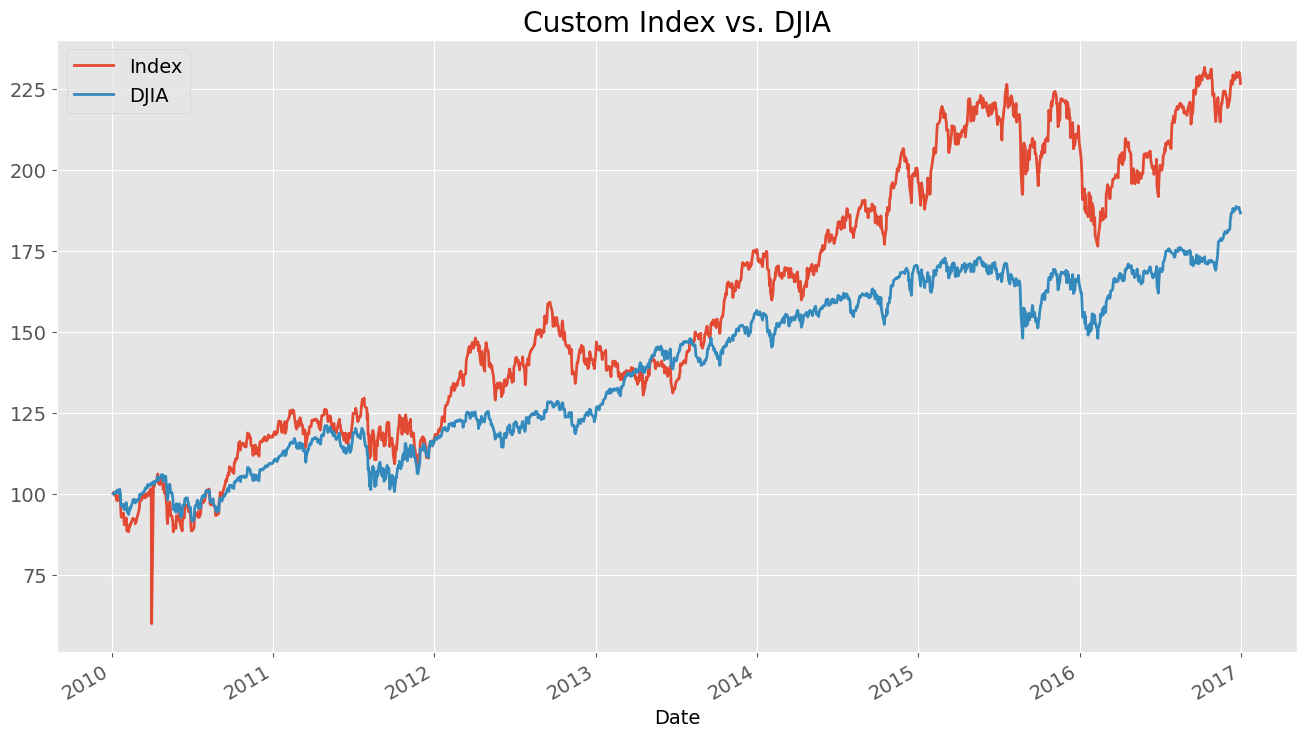

In [40]:
# Turn the index we created into a DataFrame
custom_index = index.to_frame('Index')

# Import the DJIA data here
djia = pd.read_csv(data/'djia.csv', index_col='date', parse_dates=['date'])

# Join the two indices here
custom_index['DJIA'] = djia

# Normalize both indices here
custom_index['DJIA'] = custom_index['DJIA'].div(custom_index['DJIA'].iloc[0]).mul(100)
print(custom_index)

# Plot the two indices here
custom_index.plot(title='Custom Index vs. DJIA')
plt.show()


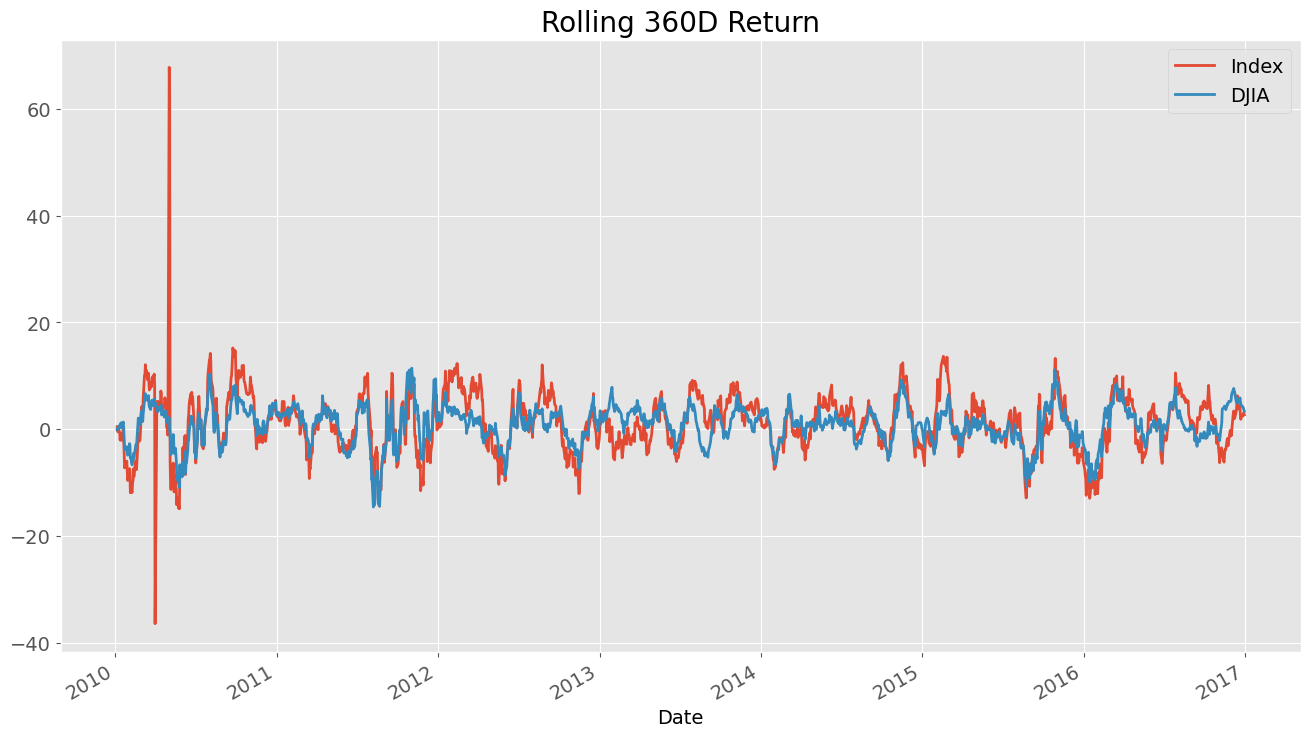

In [41]:
# Create multi_period_return function here
def multi_period_return(r):
    return (np.prod(r + 1) - 1) * 100

# Calculate rolling_return_360
rolling_return_360 = custom_index.pct_change().rolling('30D').apply(multi_period_return)

# Plot rolling_return_360 here
rolling_return_360.plot(title='Rolling 360D Return')
plt.show()

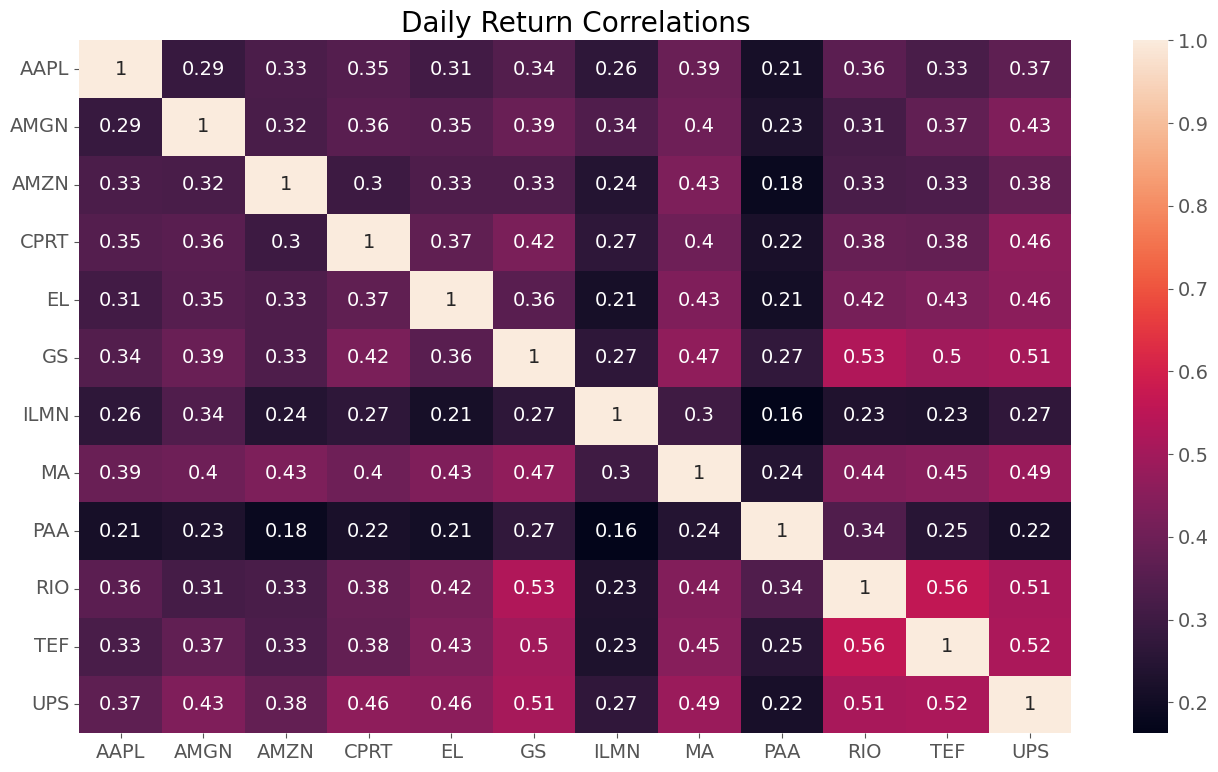

In [42]:
# Calculate the daily returns
returns = stock_prices.pct_change()

# Calculate and print the pairwise correlations
correlations = returns.corr()

# Plot a heatmap of daily return correlations
sns.heatmap(correlations, annot=True)
plt.title('Daily Return Correlations')
plt.show()

In [43]:
# Save our index in excel
results = stock_prices.join(custom_index)

# Calculate returns
returns = results.pct_change()

# Export to excel
with pd.ExcelWriter('results.xlsx') as writer:
    results.to_excel(writer, sheet_name='Index')
    returns.to_excel(writer, sheet_name='Returns')

## Correlation, Autocorrelation and ARIMA Models

### Correlation and Autocorelation

In [44]:
# We already talked about correlation so now we will work with linear regression 
# to see how well a stock price can be predicted by another stock price.

stock_prices

Y = stock_prices['AAPL'].dropna()
x = stock_prices.drop('AAPL', axis=1).dropna()

X1 = sm.add_constant(x)

model = sm.OLS(Y, X1).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1212.
Date:                Wed, 05 Apr 2023   Prob (F-statistic):               0.00
Time:                        13:36:26   Log-Likelihood:                -6489.4
No. Observations:                1761   AIC:                         1.300e+04
Df Residuals:                    1749   BIC:                         1.307e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.6349      4.039     19.471      0.0

Auto correlation is the correlation of a time series with a lagged version of itself. With regards to financial data there are some important things to keep in mind. When auto correlation is negative that is also referred to as mean reversion. When auto correlation is positive that is also referred to as momentum. There are different startegies for different types of investments for example:

Momentum strategies are used for stocks and mean reversion strategies are used for bonds

In [45]:
# We'll use the apple stock for an example:

AAPL = stock_prices['AAPL'].dropna()

AAPL_weekly = AAPL.resample('W').last()
AAPL_returns = AAPL_weekly.pct_change()

autocorrelation = AAPL_returns.autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(autocorrelation))

# Convert the daily data to annual data
yearly_rates = AAPL_weekly.resample(rule='A').last()

# Repeat above for annual data
yearly_diff = yearly_rates.pct_change()
autocorrelation_yearly = yearly_diff.autocorr()
print("The autocorrelation of annual returns is %4.2f" %(autocorrelation_yearly))


The autocorrelation of weekly returns is -0.11
The autocorrelation of annual returns is -0.24


### Plotting ACF Graphs and Reading graphs

[ 1.         -0.22122696 -0.39856504 -0.26615093  0.83479804 -0.1901038
 -0.3475634  -0.23140368  0.71995993 -0.15661007 -0.29766783 -0.22097189
  0.61656933 -0.15022869 -0.27922022 -0.22465946  0.5725259 ] 



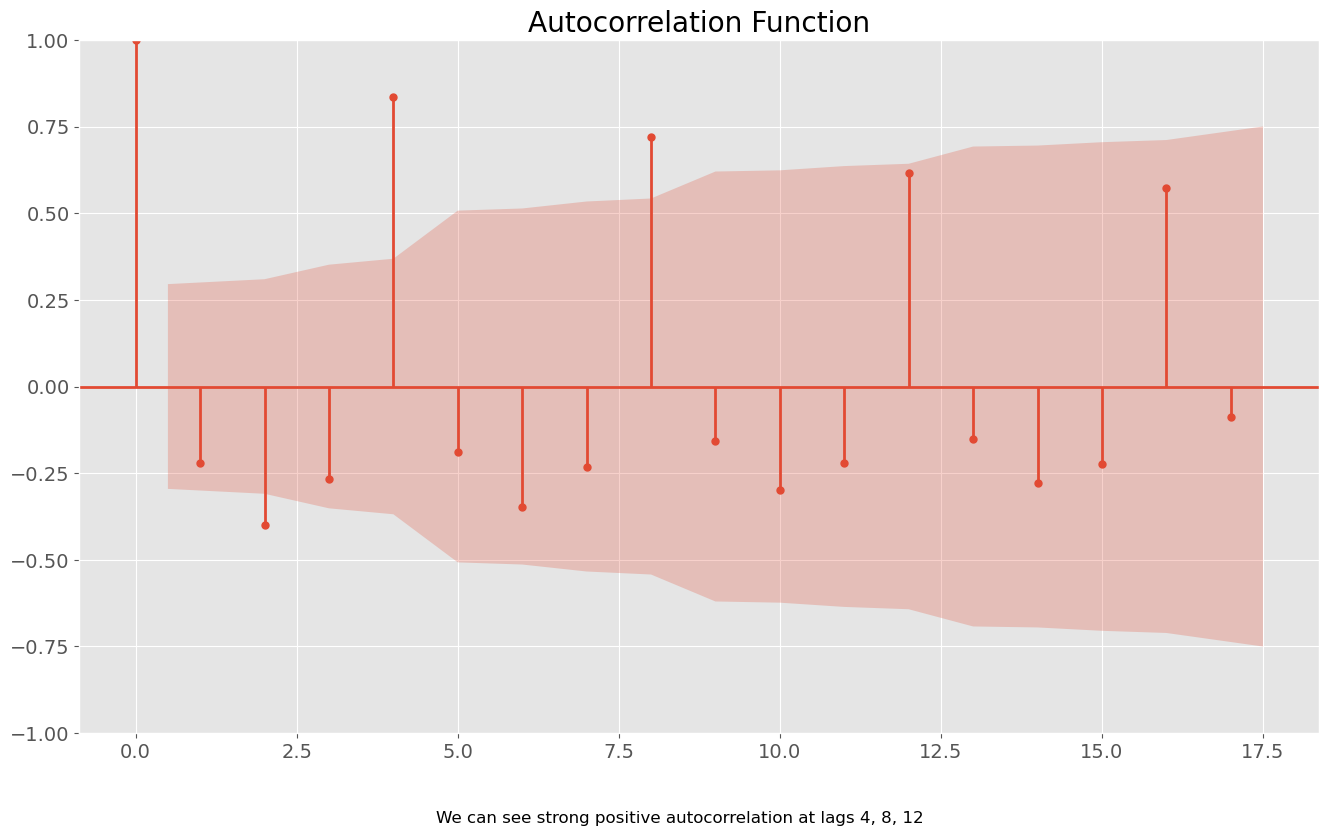

In [46]:
# For this example we will use the MSFT stock

HRB = pd.read_csv(data/'HRB.csv')

# Convert the date column to datetime
HRB['date'] = pd.to_datetime(HRB['Quarter'])
HRB.set_index('date', inplace=True)
HRB.drop('Quarter', axis=1, inplace=True)

# Compute the acf array of HRB
acf_array = acf(HRB)
print(acf_array,'\n')

# Plot the acf function
plot_acf(HRB, alpha=0.05)
plt.title('Autocorrelation Function')
plt.figtext(0.5, 0.01, 'We can see strong positive autocorrelation at lags 4, 8, 12', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

The autocorrelation of weekly MSFT returns is -0.16
The approximate confidence interval is +/- 0.12


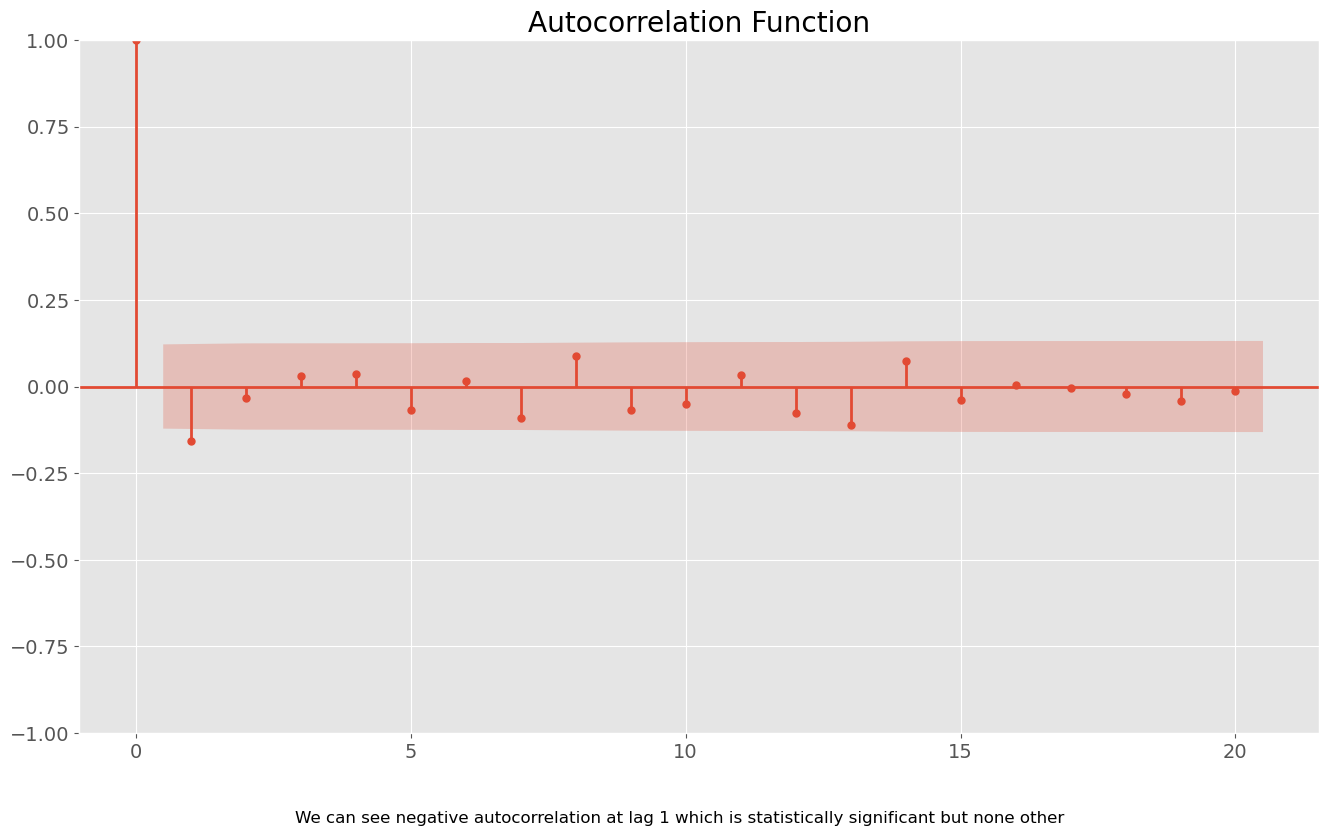

In [47]:
# We'll now use MSFT stock for this example
# Remember to remove NAs

MSFT = pd.read_csv(data/'MSFT.csv', parse_dates=['Date'] ,index_col='Date')


weekly_returns = MSFT.resample('W').last().pct_change().dropna()

# Compute and print the autocorrelation of MSFT weekly returns
autocorrelation = weekly_returns['Adj Close'].autocorr()
print("The autocorrelation of weekly MSFT returns is %4.2f" %(autocorrelation))

# Find the number of observations by taking the length of the returns DataFrame
nobs = len(weekly_returns)

# Compute the approximate confidence interval
conf = 1.96/np.sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))

# Plot the acf function
plot_acf(weekly_returns, alpha=0.05, lags=20)
plt.title('Autocorrelation Function')
plt.figtext(0.5, 0.01, 'We can see negative autocorrelation at lag 1 which is statistically significant but none other', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

### White Noise and Random Walk

White noise refers to a time series that has no correlation with itself at different lags. We can generate white noise using the numpy.random.normal() function. Similarly stocks can be modeled as white noise to which end we state that if stock returns are white noise then they are uncorrelated with themselves at different lags. We can test this by computing the autocorrelation of the returns and checking if it is statistically significant. As we could see in the case of MSFT it was not. If the return of a stock is white noise then the price is said to be a random walk which is:

$ P_t = \mu + P_{t-1} + \epsilon_t$

Test for random walk:

$ P_t = \alpha +\beta P_{t-1} + \epsilon_t$

Test:

$H_0 : \beta = 1$ (random walk)

$H_1 : \beta < 1$ (not random walk)

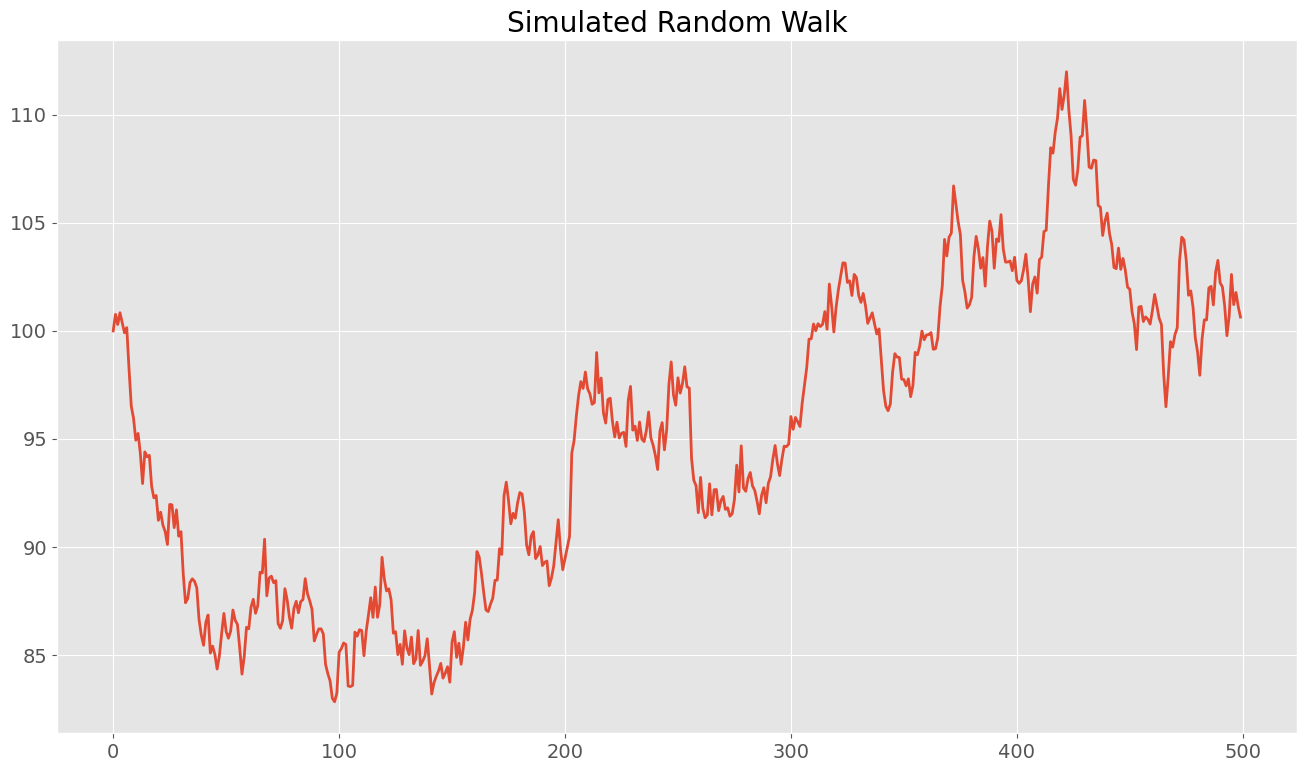

In [48]:
# Generate 500 random steps with mean=0 and standard deviation=1
steps = np.random.normal(loc=0, scale=1, size=500)
# Set first element to 0 so that the first price will be the starting stock price
steps[0]=0
# Simulate stock prices, P with a starting price of 100
P = 100 + np.cumsum(steps)
# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk")
plt.show()

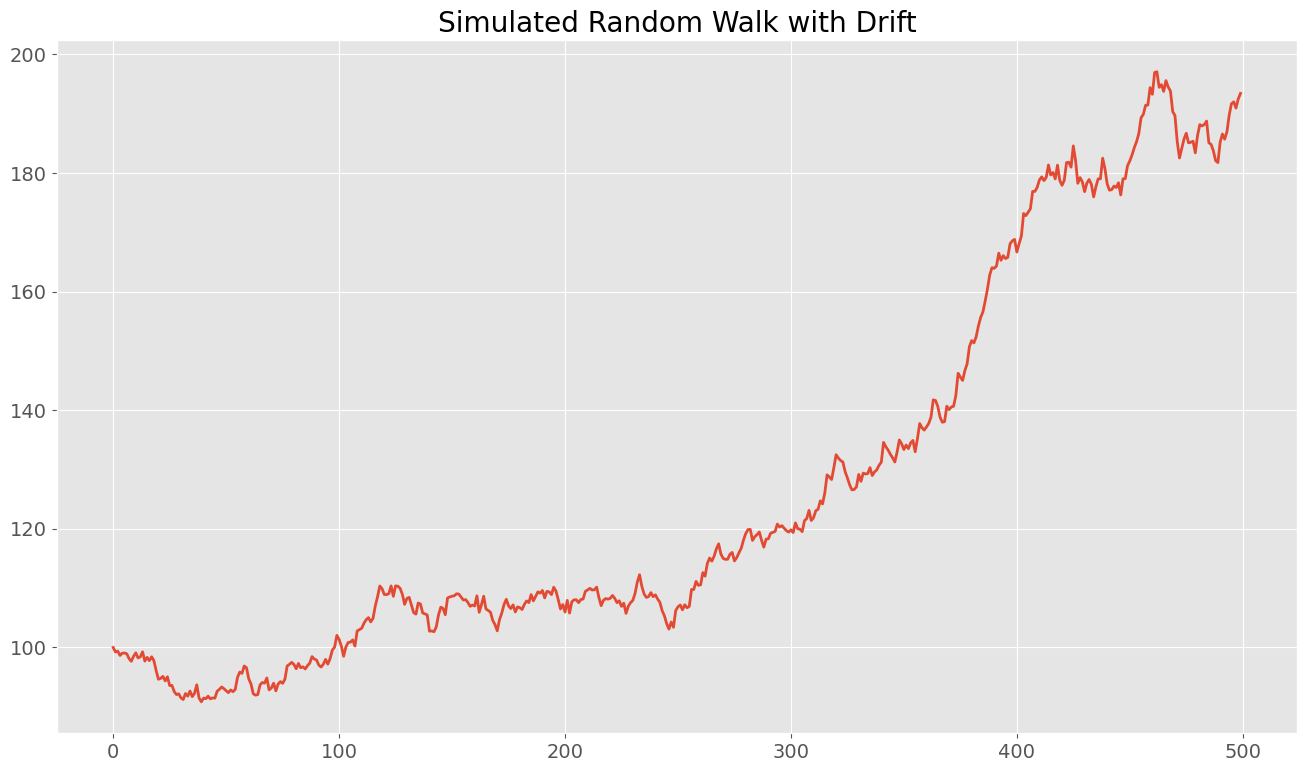

In [49]:
# Generate 500 random steps
steps_returns = np.random.normal(loc=0.001, scale=0.01, size=500) + 1
# Set first element to 1
steps_returns[0]=1
# Simulate the stock price, P, by taking the cumulative product
P_r = 100 * np.cumprod(steps_returns)

# Plot the simulated stock prices
plt.plot(P_r)
plt.title("Simulated Random Walk with Drift")
plt.show()

In [50]:
# Import data for AMZN stocks
AMZN = pd.read_csv(data/'AMZN.csv', parse_dates=['Date'], index_col='Date')

# Run the ADF test on the price series and print out the results
results = adfuller(AMZN['Adj Close'])
print(results)
# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(4.025168525770738, 1.0, 33, 5054, {'1%': -3.4316445438146865, '5%': -2.862112049726916, '10%': -2.5670745025321304}, 30308.64216426981)
The p-value of the test on prices is: 1.0


In [51]:
# Create a DataFrame of AMZN returns
AMZN_ret = AMZN.pct_change()
# Eliminate the NaN in the first row of returns
AMZN_ret = AMZN_ret.dropna()
# Run the ADF test on the return series and print out the p-value
results = adfuller(AMZN_ret)
# results of adfuller is a tuple, the p-value is the second element
print('The p-value of the test on returns is: ' + str(results[1]))

The p-value of the test on returns is: 2.565589808349319e-22


Now we will look at stationarity of a time series. Stationarity means that a time series is stationary if its statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. It is important to check for stationarity before doing any analysis on a time series. If a time series is not stationary, then we need to transform it to make it stationary by differencing, taking the log, etc.

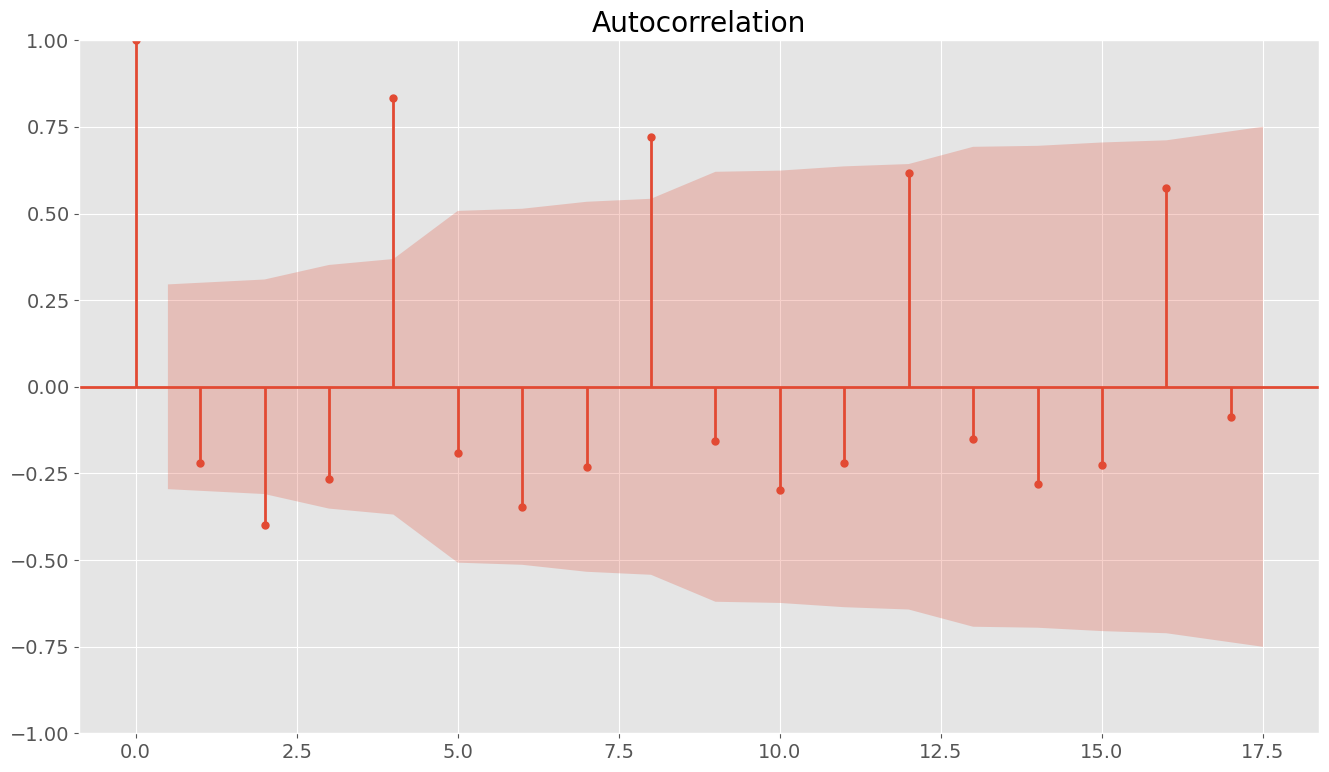

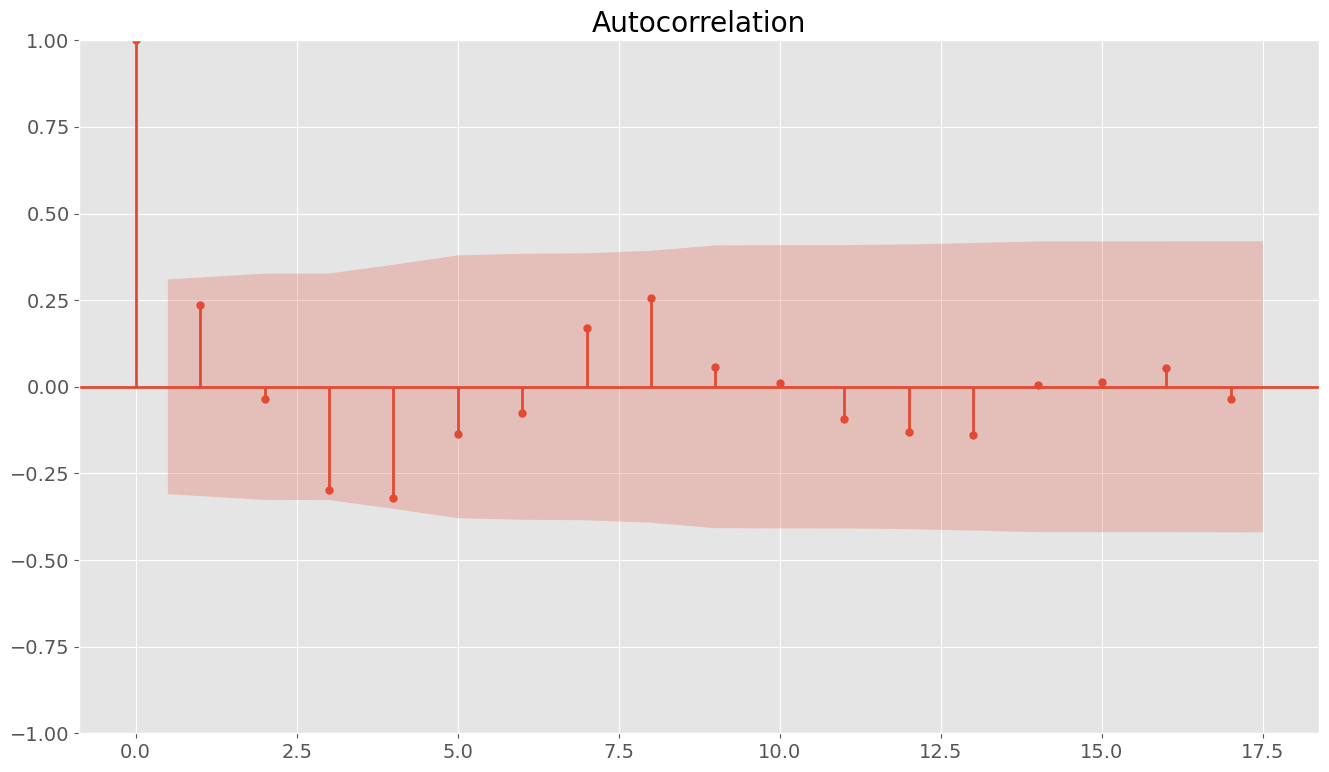

In [52]:
# We'll use HRB data for this example
plot_acf(HRB) 

# We can see that there is a strong positive autocorrelation at lags 4, 8, 12 due to a seasonal pattern
# We'll remove the seasonal pattern by differencing the data
HRBsa = HRB.diff(4).dropna()

# Plot the acf function
plot_acf(HRBsa)
plt.show()

### Describing an AR Model

The equation for an AR Model is as follows:

$R_t  = \mu + \phi R_{t-1} + \epsilon_t$

* Since only one lagged value this is known as AR model of order 1 or, AR(1) model
* For stationarity, -1 < $\phi$ < 1
* Negtive $\phi$: Mean Reversion
* Positive $\phi$: Momentum


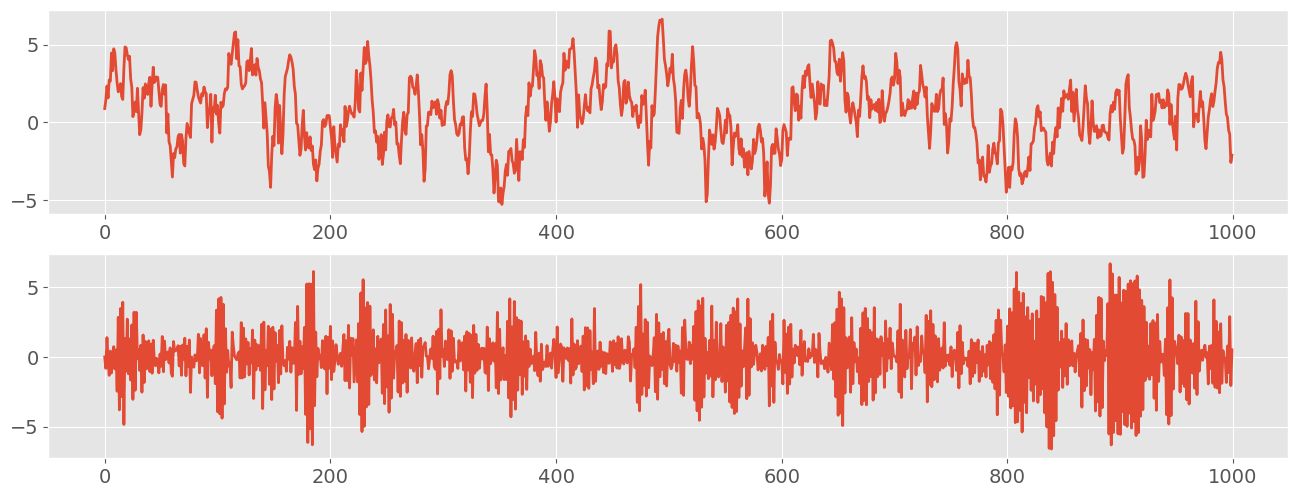

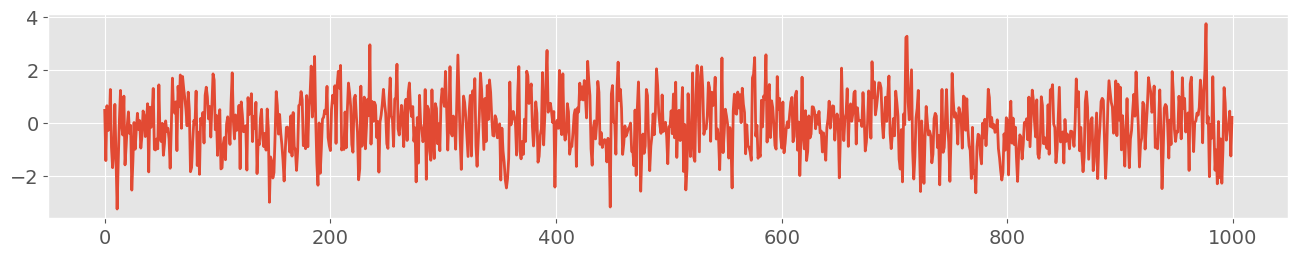

In [53]:
# Plot 1: AR parameter = +0.9
plt.subplot(3,1,1)
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: AR parameter = -0.9
plt.subplot(3,1,2)
ar2 = np.array([1, 0.9])
ma2 = np.array([1])
AR_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = AR_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)
plt.show()

plt.subplot(3,1,3)
ar3 = np.array([1, -0.3])
ma3 = np.array([1])
AR_object3 = ArmaProcess(ar3, ma3)
simulated_data_3 = AR_object3.generate_sample(nsample=1000)
plt.plot(simulated_data_3)
plt.show()


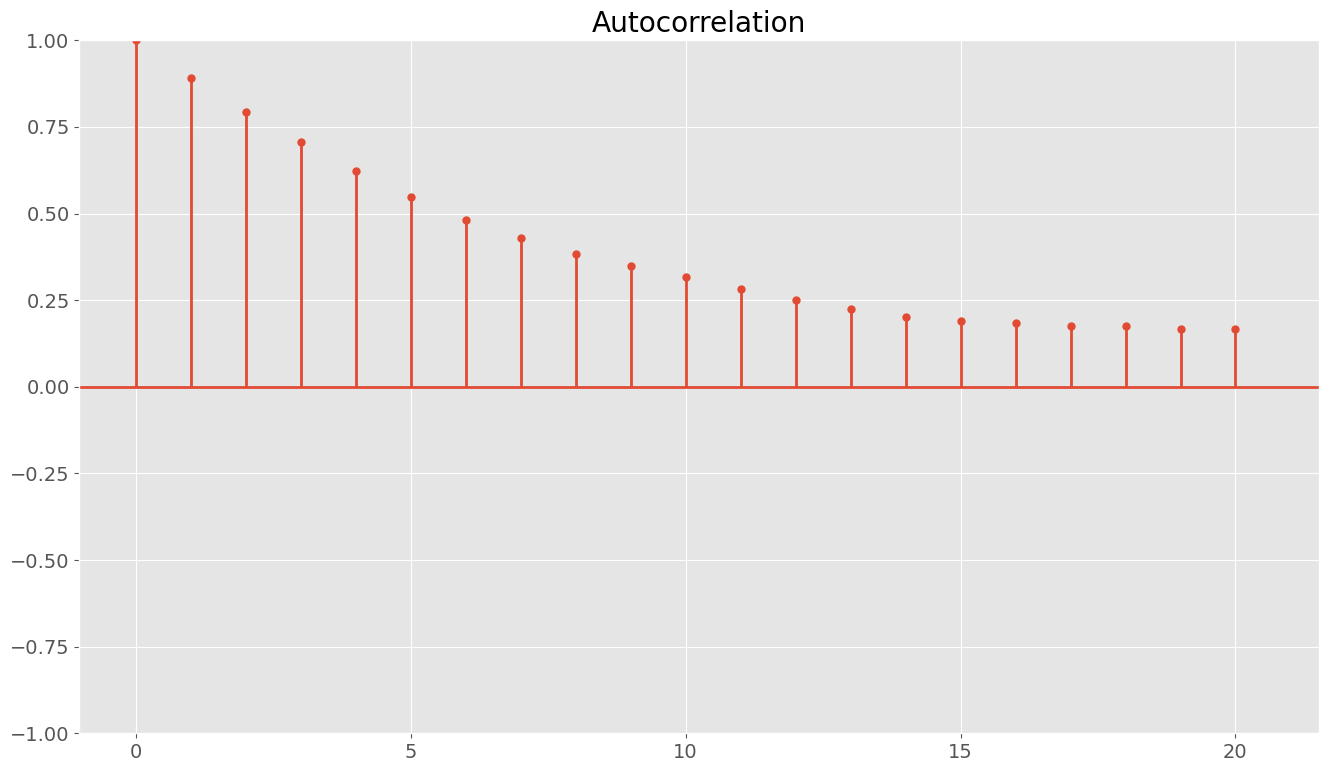

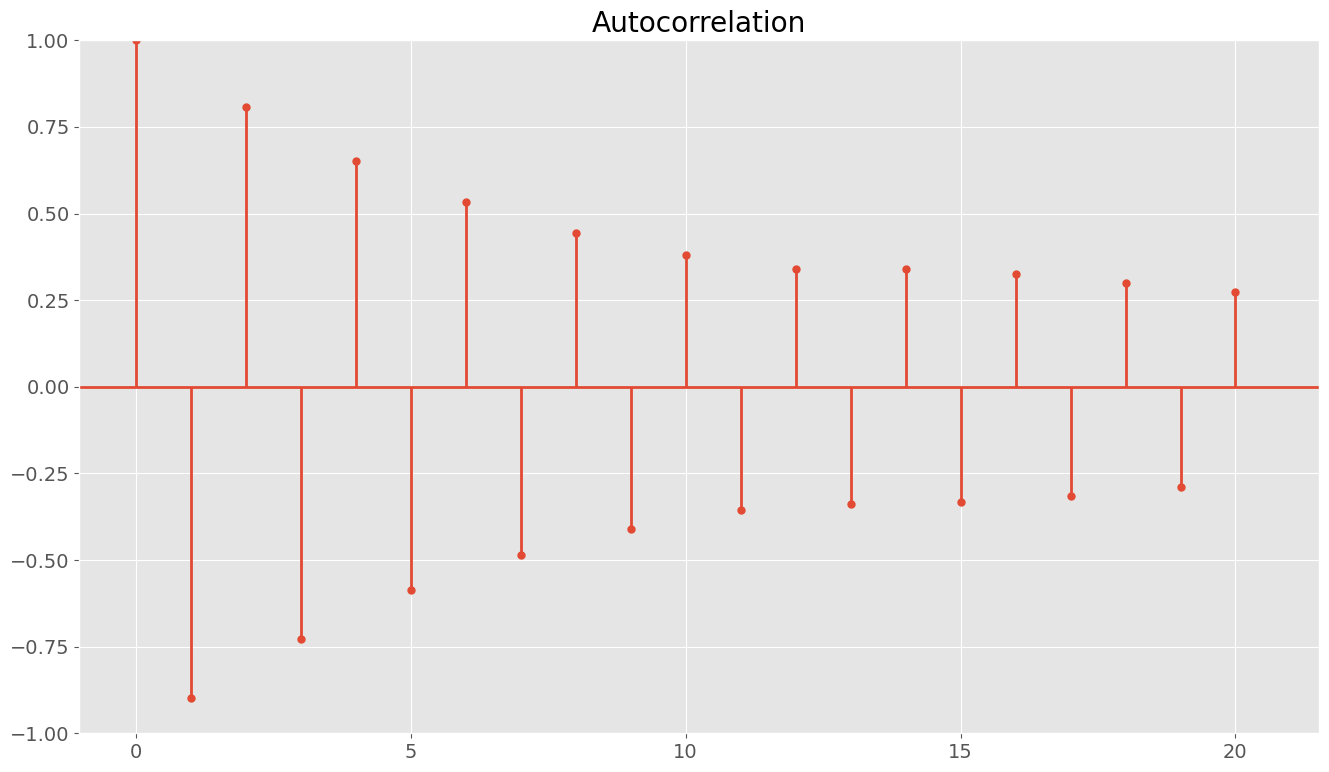

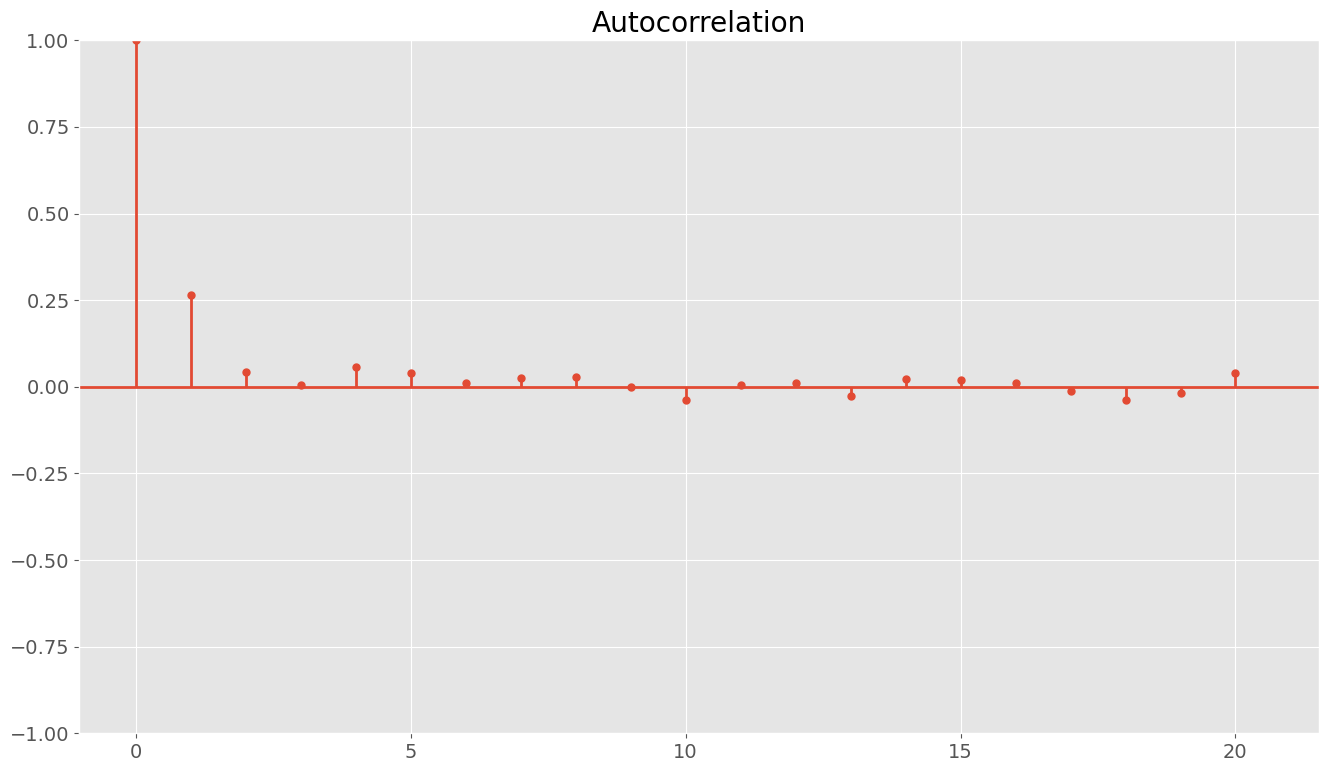

In [54]:
# Plot 1: AR parameter = +0.9
plot_acf(simulated_data_1, alpha=1, lags=20)
plt.show()

# Plot 2: AR parameter = -0.9
plot_acf(simulated_data_2, alpha=1, lags=20)
plt.show()

# Plot 3: AR parameter = +0.3
plot_acf(simulated_data_3, alpha=1, lags=20)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1417.065
Date:                Wed, 05 Apr 2023   AIC                           2840.130
Time:                        13:36:32   BIC                           2854.854
Sample:                             0   HQIC                          2845.726
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6428      0.289      2.223      0.026       0.076       1.209
ar.L1          0.8903      0.015     60.204      0.000       0.861       0.919
sigma2         0.9947      0.044     22.649      0.0

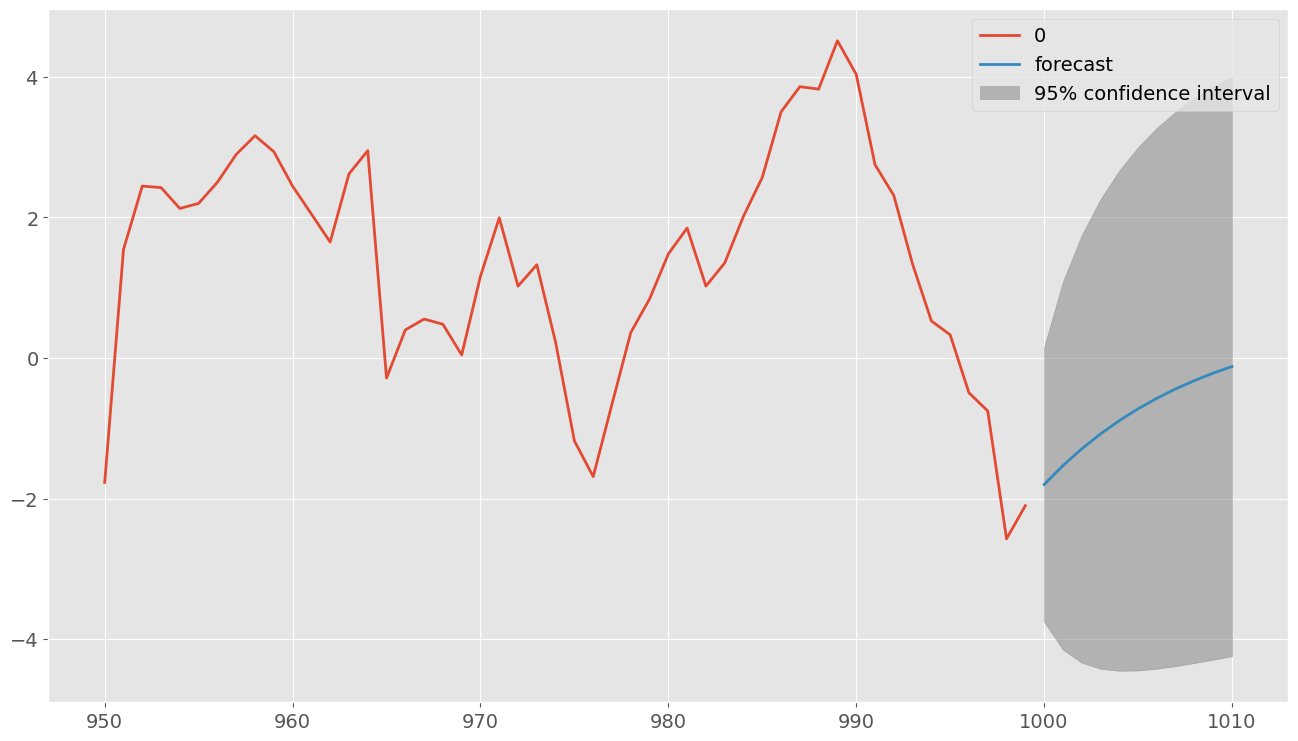

In [55]:
simulated_data_1 = pd.DataFrame(simulated_data_1)
# Fit an AR(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(1,0,0))
res = mod.fit()

# Print out summary information on the fit
print(res.summary(),'\n')

# Print out the estimate for phi
print("When the true phi=0.9, the estimate of phi is:")
print(res.params[1],'\n')

# Plot the data and the forecast
fig, ax = plt.subplots()
simulated_data_1[950:].plot(ax=ax)
plot_predict(res, start=1000, end=1010, ax=ax)
plt.show()

In instance where we do not know the order of the AR model, we can use the Akaikes Information Criterion (AIC) and the Bayesian Information Criterion (BIC) to select the best model. This is done by fitting many different AR models of different orders, and then selecting the one with the lowest AIC or BIC. We also plot the ACF and PACF to help us select the best model

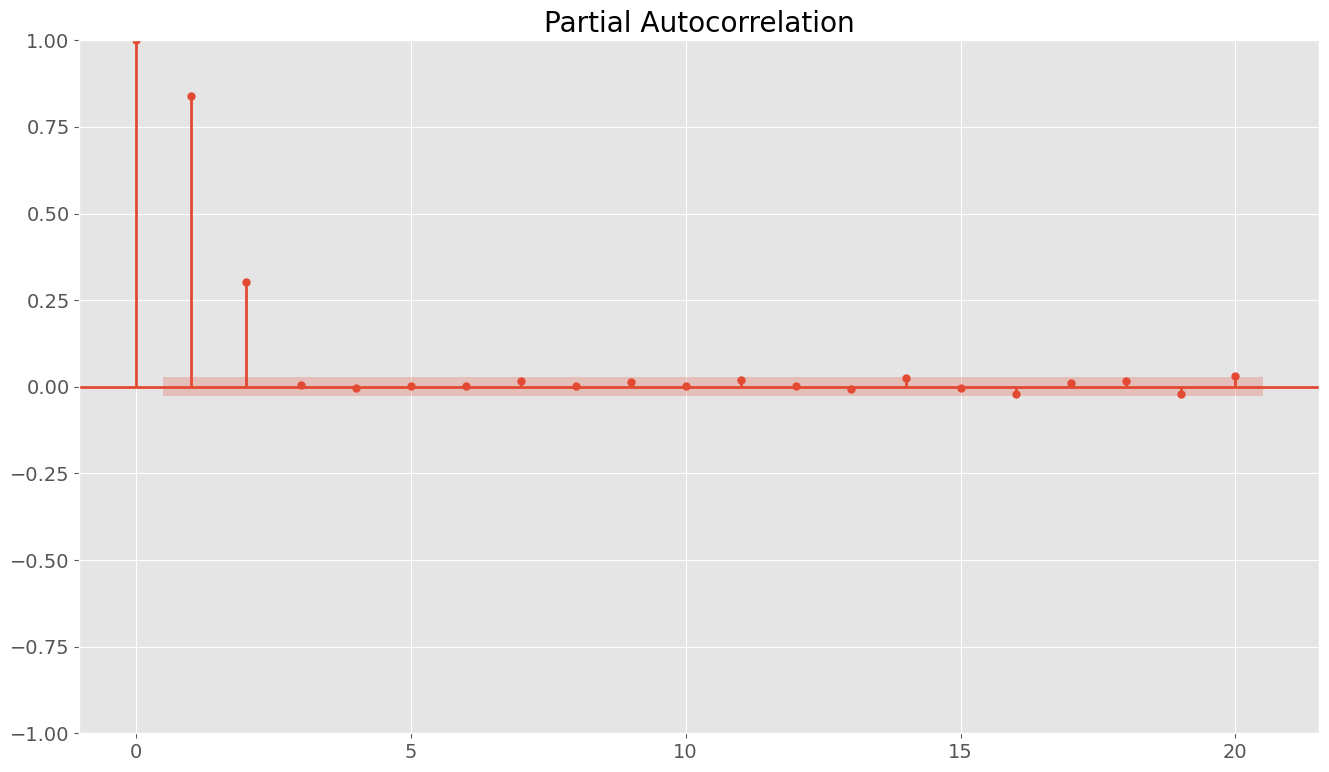

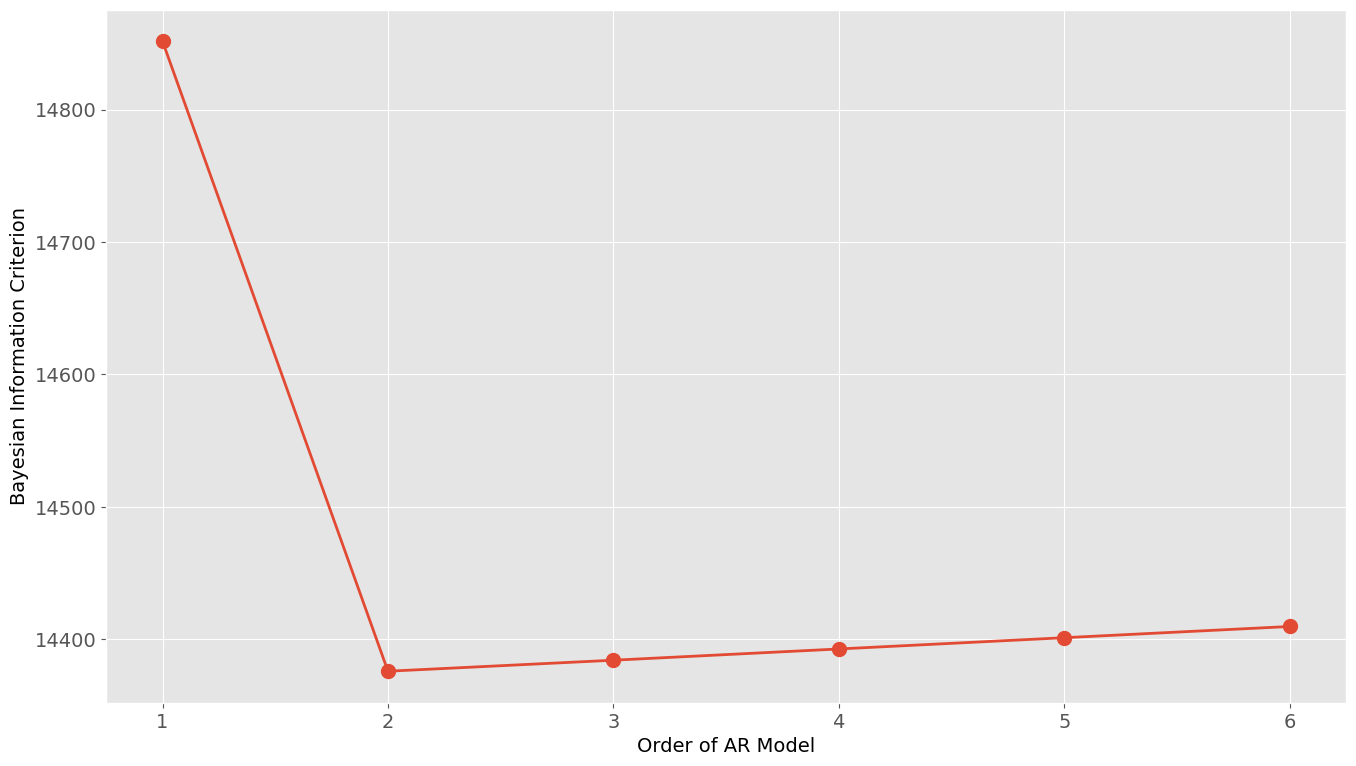

In [56]:
# Simulate AR(2) with phi1=+0.6, phi2=+0.3
ma = np.array([1])
ar = np.array([1, -0.6, -0.3])
AR_object = ArmaProcess(ar, ma)
simulated_data_4 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(2)
plot_pacf(simulated_data_4, lags=20)
plt.show()

# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(simulated_data_4, order=(p,0,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

Based on the plot above we can note that the best model would be AR(2) model

### Moving Average Models

In Moving Average model:

$R_t = \mu + \epsilon_t + \theta\epsilon_{t-1}$

* Since only one lagged error on right-hand side this is called MA(1) model 
* MA parameter is $\theta$
* Stationary for all values of $\theta$

For moving average models:

* Negative $\theta$: One_Period Mean Reversion
* Positive $\theta$: One_Period Momentum

Note: One-period autocorrelation is $\theta / (1+ \theta)^2$

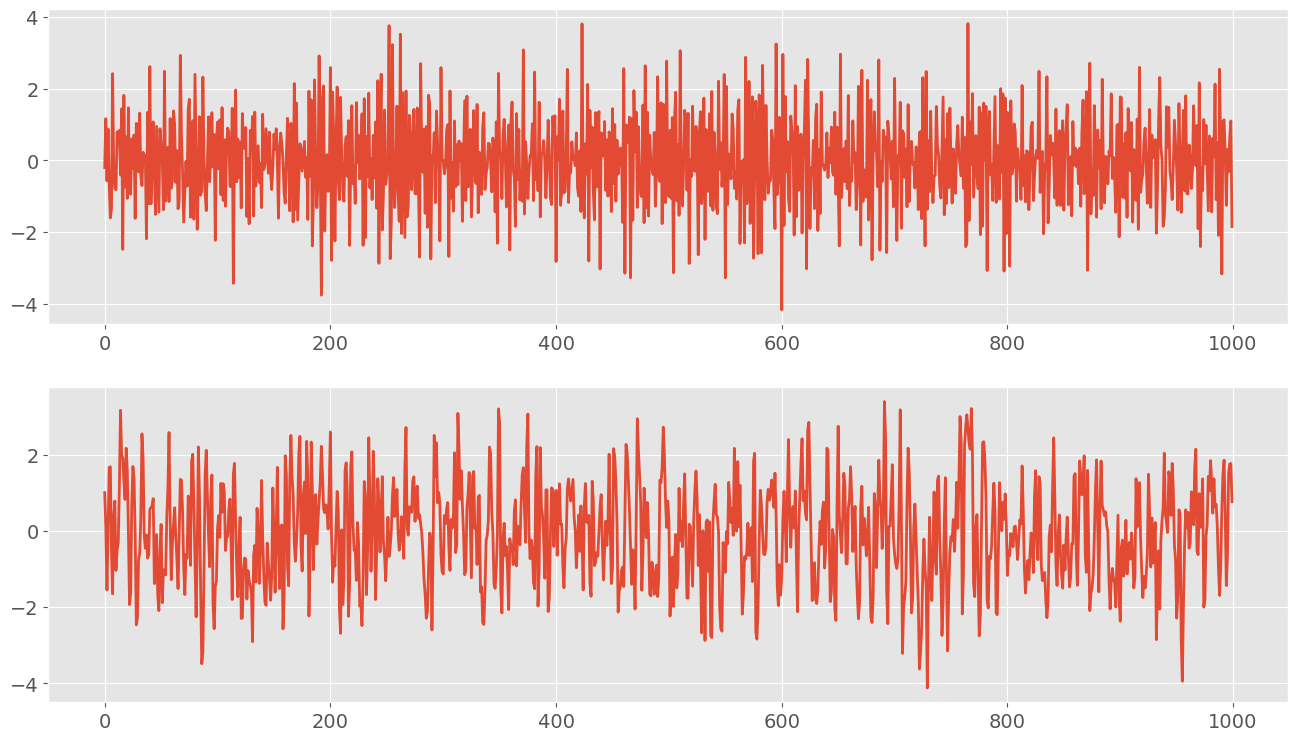

In [57]:
# Plot 1: MA parameter = -0.9
plt.subplot(2,1,1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: MA parameter = +0.9
plt.subplot(2,1,2)
ar2 = np.array([1])
ma2 = np.array([1, 0.9])
MA_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = MA_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)

plt.show()

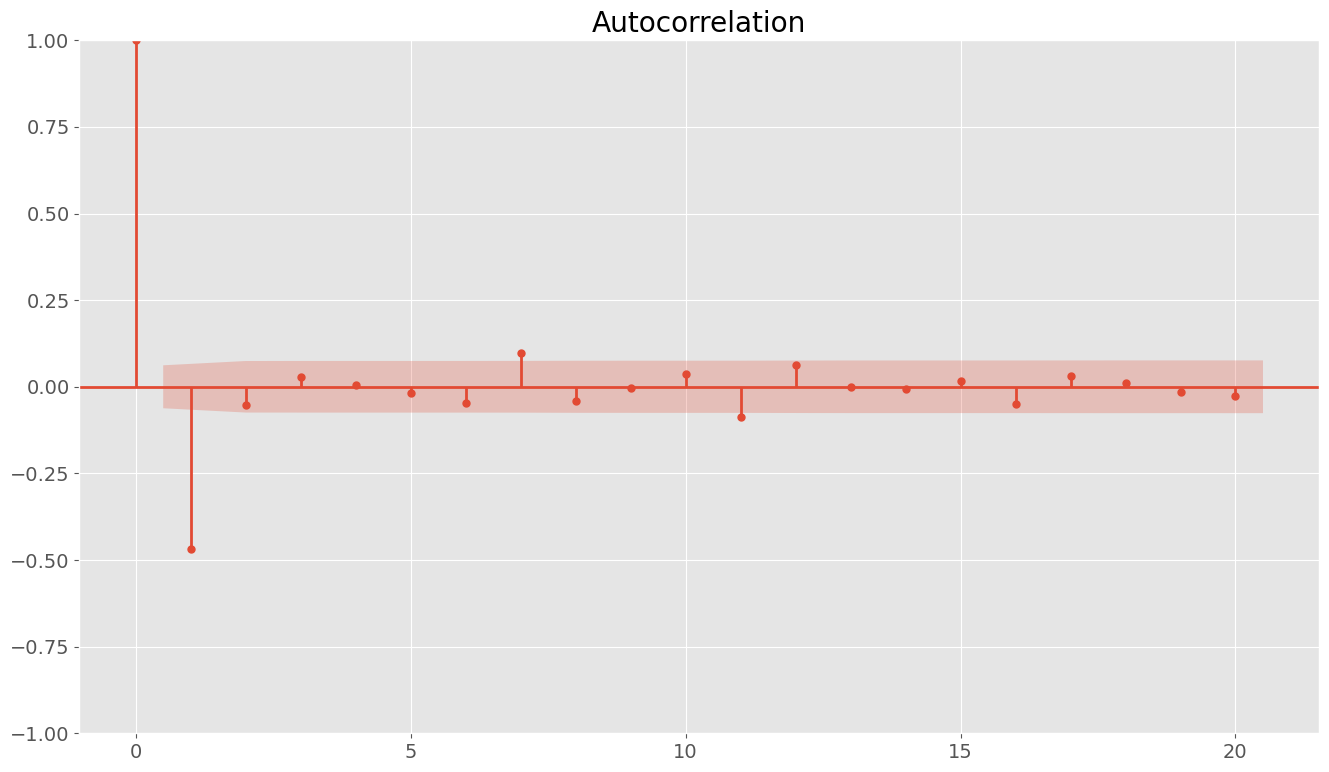

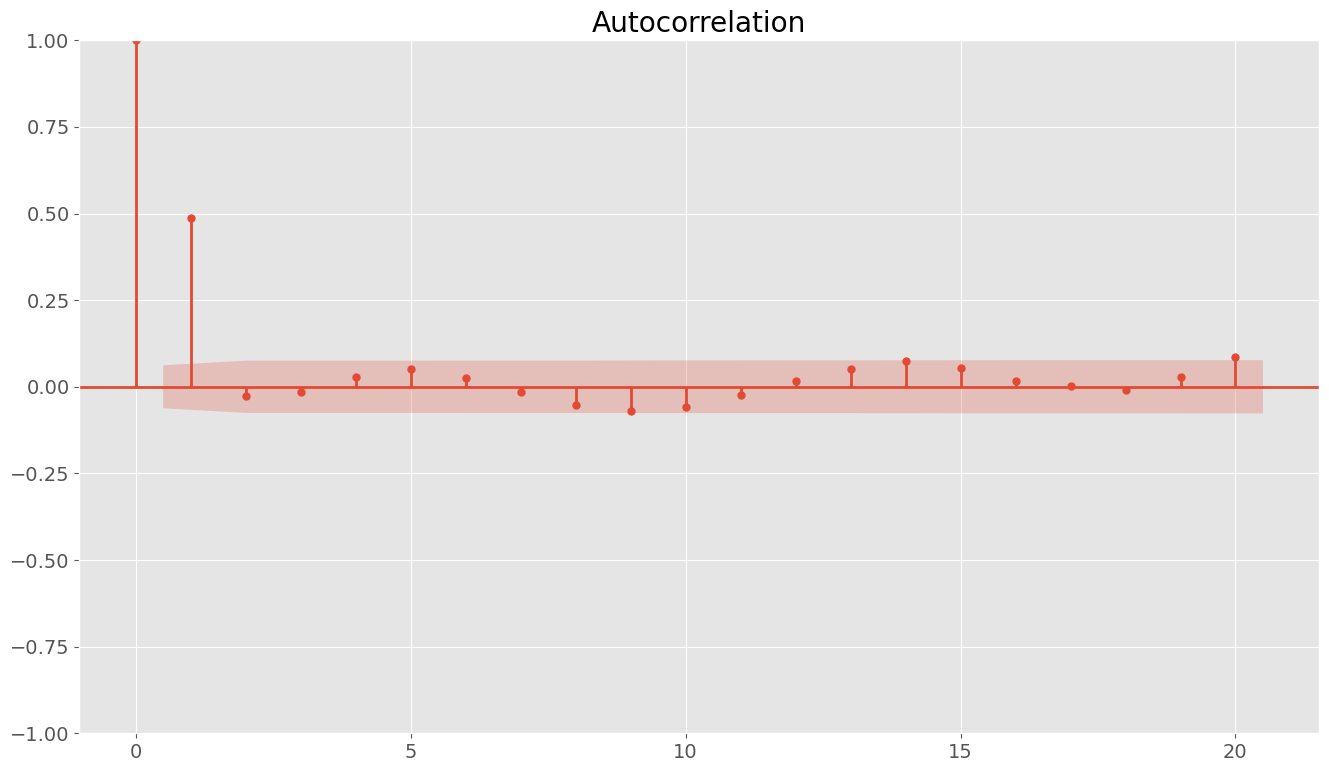

In [58]:
# Creating acf plots for previous plots
plot_acf(simulated_data_1, lags=20)
plt.show()

plot_acf(simulated_data_2, lags=20)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1380.241
Date:                Wed, 05 Apr 2023   AIC                           2766.481
Time:                        13:36:44   BIC                           2781.205
Sample:                             0   HQIC                          2772.077
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.002     -0.429      0.668      -0.006       0.004
ma.L1         -0.9199      0.012    -75.722      0.000      -0.944      -0.896
sigma2         0.9238      0.043     21.672      0.0

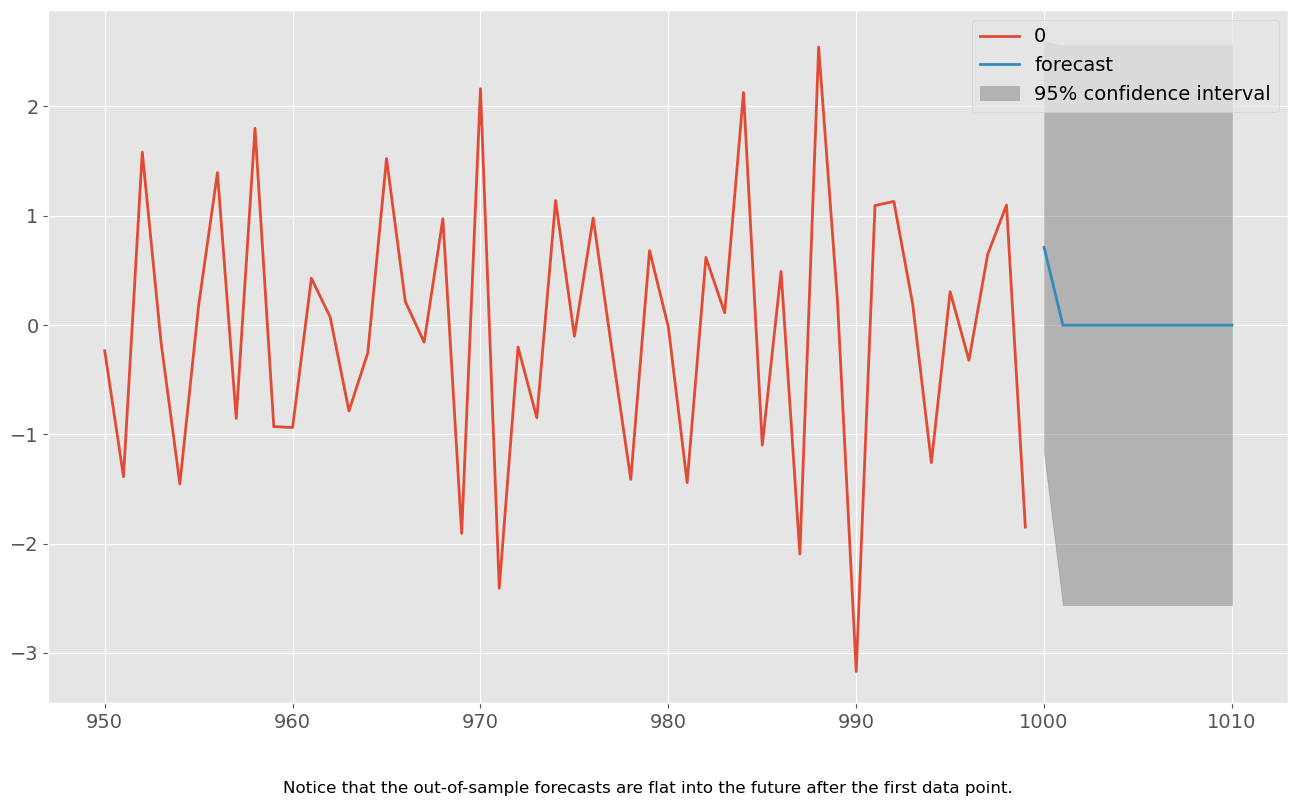

In [59]:
# Fit an MA(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(0,0,1))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta is:")
print(res.params[1],'\n')

# Plot the data and the forecast
simulated_data_1 = pd.DataFrame(simulated_data_1)
mod = ARIMA(simulated_data_1, order=(0,0,1))
res = mod.fit()
fig, ax = plt.subplots()
simulated_data_1.loc[950:].plot(ax=ax)
plot_predict(res, start=1000, end=1010, ax=ax)
#add caption
plt.figtext(0.5, 0.01, 'Notice that the out-of-sample forecasts are flat into the future after the first data point.', wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

### ARMA Models

A combination of both AR and MA models have an equation as follows for ARMA(1,1):

$R_t = \mu + \phi R_{t-1} + \epsilon_t + \theta\epsilon_{t-1}$

The following would a standard operating procedure to check and fill in missing data

If there were no missing rows, there would be 391 rows of minute data
The actual length of the DataFrame is: 389
Missing rows:  {182, 14}
The actual length of the DataFrame now is: 391


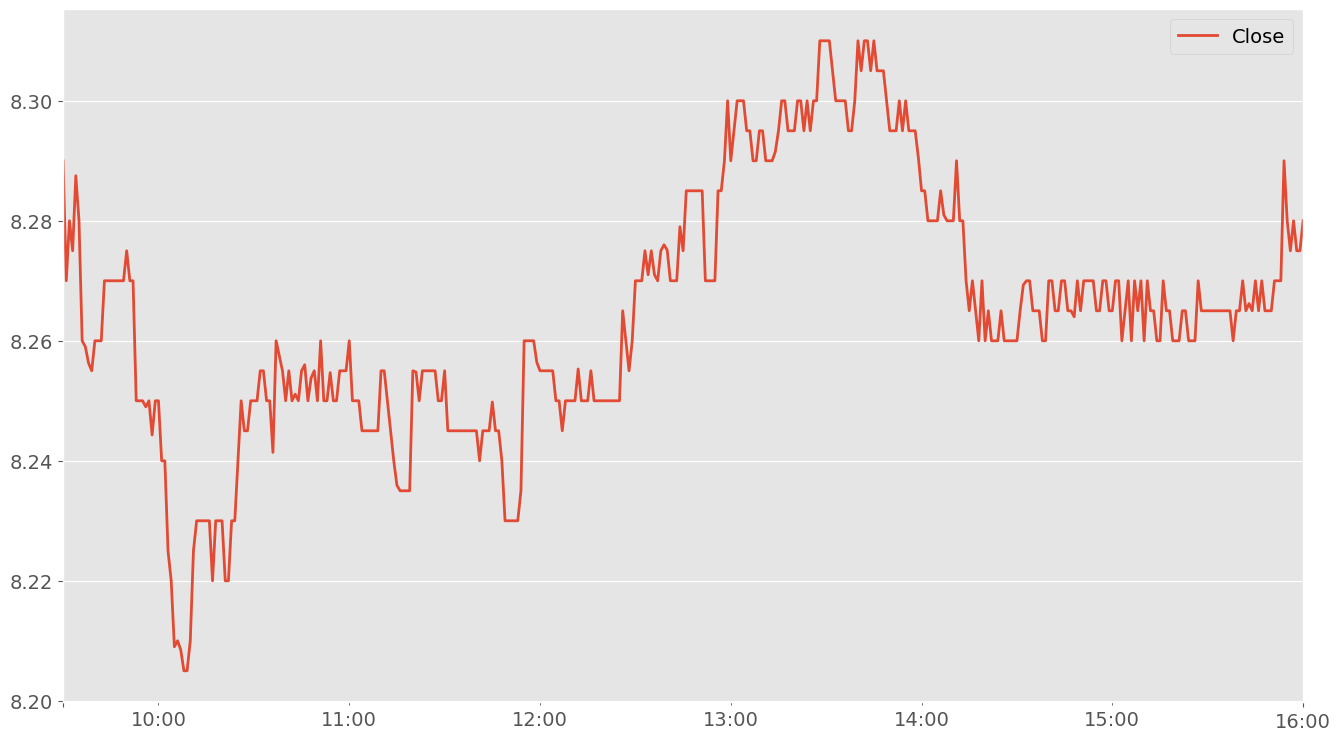

In [60]:
# Import sprint_intraday text file and convert to dataframe
# The DataFrame intraday contains one day's prices (on September 1, 2017) for Sprint stock (ticker symbol "S") 
# sampled at a frequency of one minute. The stock market is open for 6.5 hours (390 minutes), from 9:30am to 4:00pm.

intraday = pd.read_csv(data/'sprint_intraday.txt', sep=',', header=None).drop([2,3,4,5], axis=1)
intraday.columns = ['Date', 'Close']
intraday.iloc[0,0] = 0
intraday['Date'] = pd.to_numeric(intraday['Date'])
intraday = intraday.set_index('Date')

print("If there were no missing rows, there would be 391 rows of minute data")
print("The actual length of the DataFrame is:", len(intraday))

set_everything = set(range(391))
# The intraday index as a set
set_intraday = set(intraday.index)
# Calculate the difference
set_missing = set_everything - set_intraday
# Print the difference
print("Missing rows: ", set_missing)

# Fill in the missing rows
intraday = intraday.reindex(range(391), method='ffill')
print("The actual length of the DataFrame now is:", len(intraday))

# Change the index to the intraday times
intraday.index = pd.date_range(start='2017-09-01 9:30', end='2017-09-01 16:00', freq='1min')

# Plot the intraday time series
intraday.plot(grid=True)
plt.show()

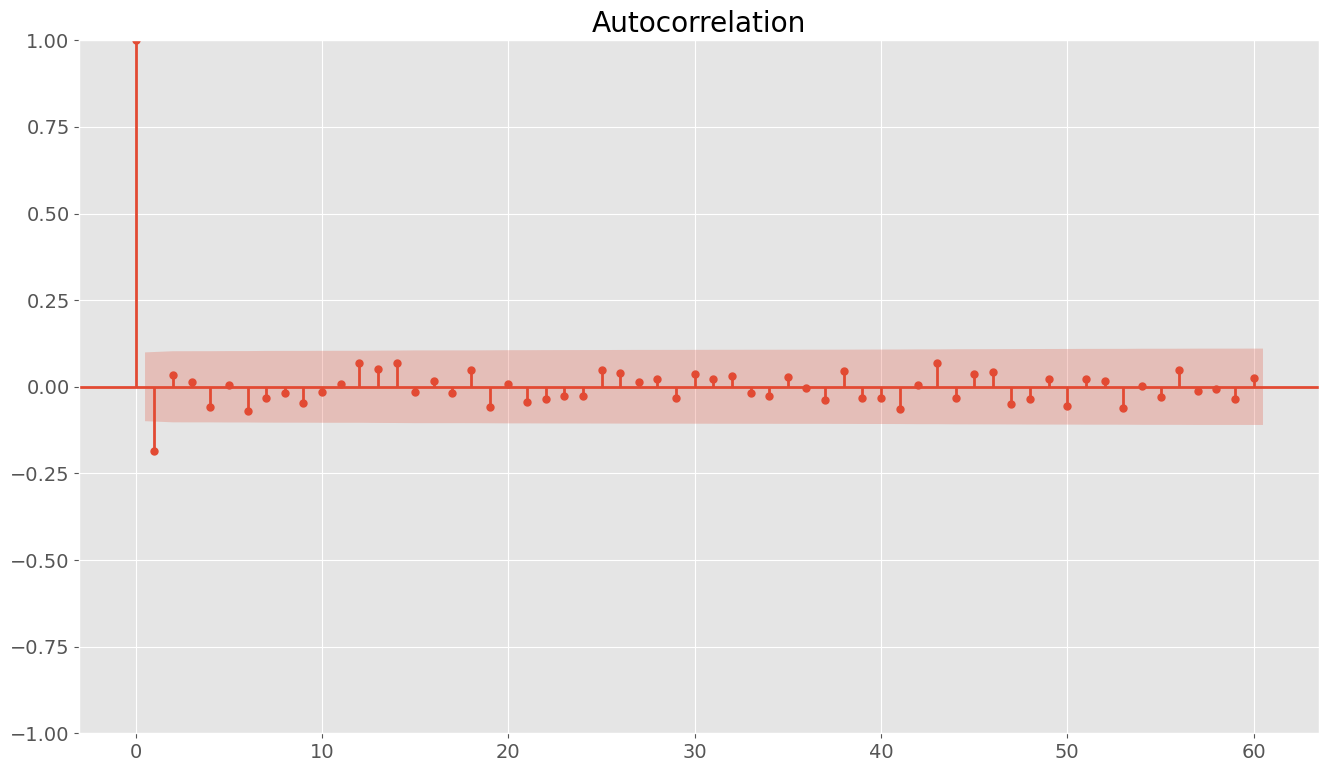

-0.171716193948006


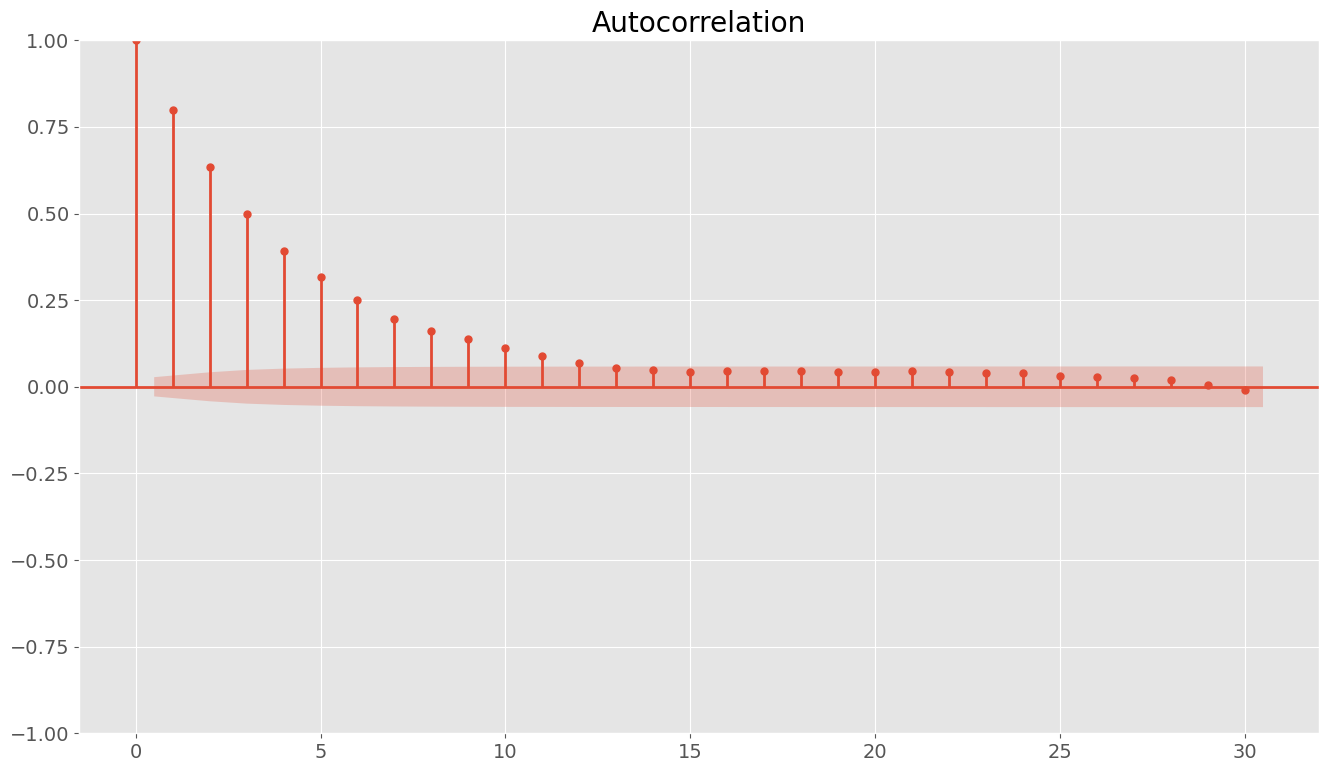

In [61]:
returns = intraday.pct_change().dropna()

# Plot ACF of returns with lags up to 60 minutes
plot_acf(returns, lags=60)
plt.show()

# Fit the data to an MA(1) model
mod = ARIMA(returns, order=(0,0,1))
res = mod.fit()
print(res.params[1])

# Build a list MA parameters
ma = [0.8**i for i in range(30)]

# Simulate the MA(30) model
ar = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_data = AR_object.generate_sample(nsample=5000)

# Plot the ACF
plot_acf(simulated_data, lags=30)
plt.show()

### Cointegration



Cointegration means that the two time series are linear combinations of each other. The two time series are cointegrated if the spread between them is stationary. An example of this would relationships between two commodoties such as oil and gas. We will further explore this example below

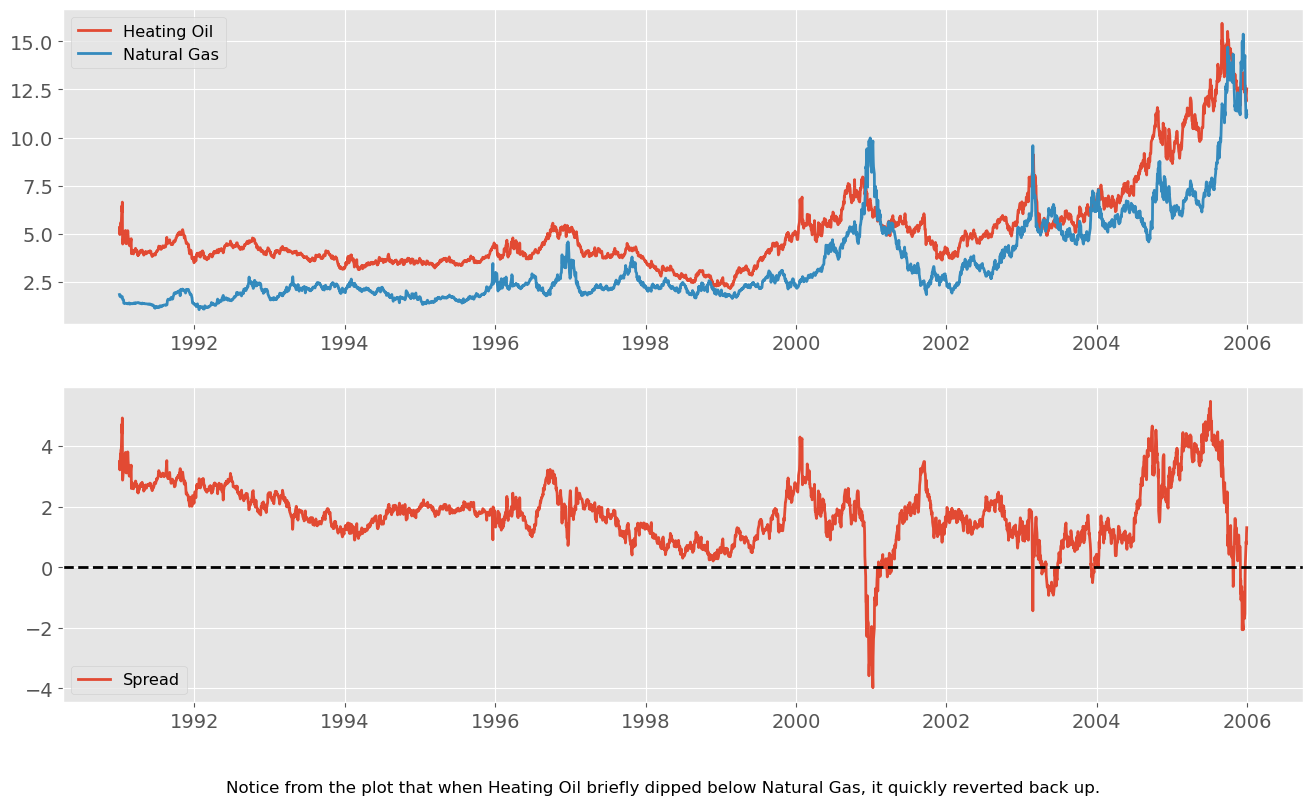

In [62]:
# import data
HO = pd.read_csv(data/'CME_HO1.csv', index_col=0, parse_dates=True)
NG = pd.read_csv(data/'CME_NG1.csv', index_col=0, parse_dates=True)

# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(7.25*HO, label='Heating Oil')
plt.plot(NG, label='Natural Gas')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(7.25*HO-NG, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.figtext(0.5, 0.01, 'Notice from the plot that when Heating Oil briefly dipped below Natural Gas, it quickly reverted back up.', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [63]:
# Compute the ADF for HO and NG
result_HO = adfuller(HO)
print("The p-value for the ADF test on HO is: ", result_HO[1],'\n',"We can reject the null hypothesis that HO is not a random walk.",'\n')
result_NG = adfuller(NG['Close'])
print("The p-value for the ADF test on NG is ", result_NG[1],'\n',"We can reject the null hypothesis that NG is not a random walk.",'\n')

# Compute the ADF of the spread
result_spread = adfuller(7.25 * HO - NG)
print("The p-value for the ADF test on the spread is ", result_spread[1],'\n',"We can reject the null hypothesis that spread between HO and NG is not a random walk.",'\n')

The p-value for the ADF test on HO is:  0.019831028071627496 
 We can reject the null hypothesis that HO is not a random walk. 

The p-value for the ADF test on NG is  0.004547284956542435 
 We can reject the null hypothesis that NG is not a random walk. 

The p-value for the ADF test on the spread is  0.00011887051827353041 
 We can reject the null hypothesis that spread between HO and NG is not a random walk. 



### Case Study: Climate Change

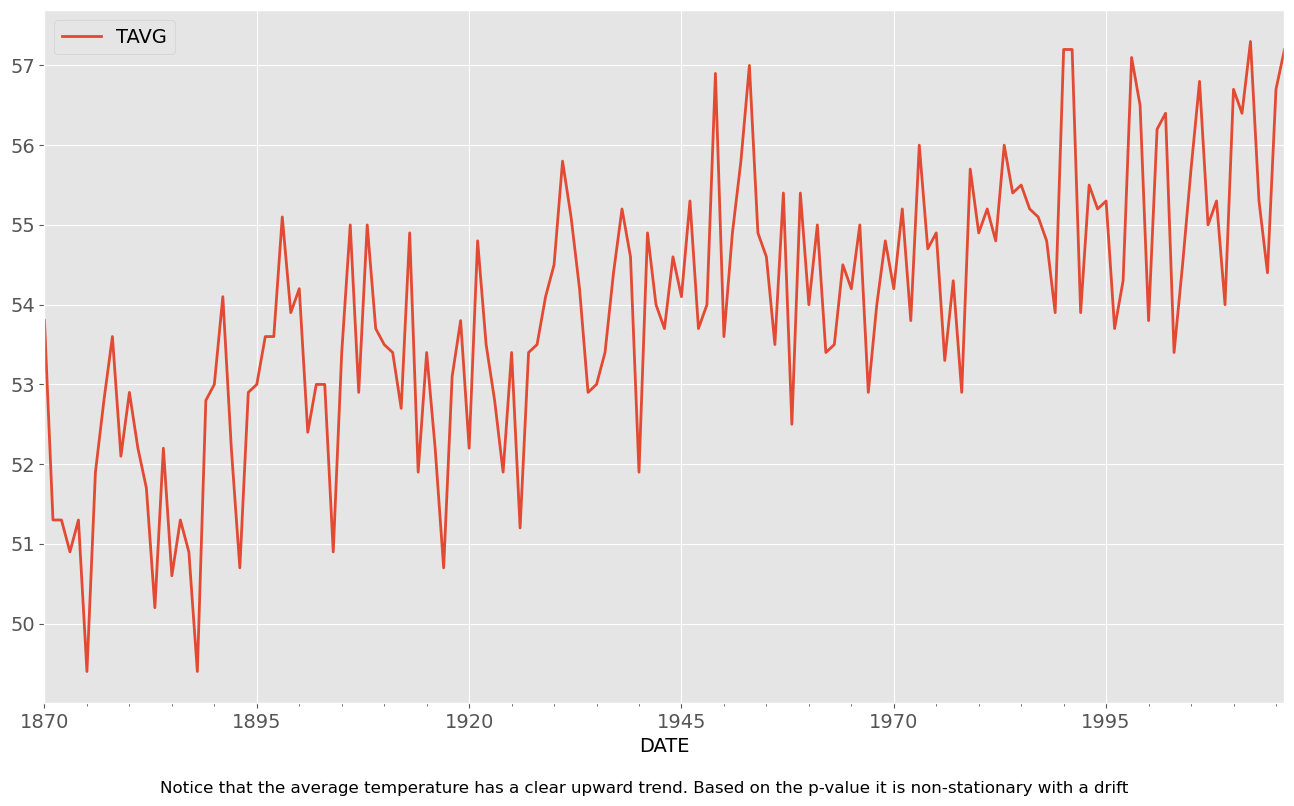

The p-value for the ADF test is  0.5832938987871104


In [64]:
Climate = pd.read_csv(data/'NOAA_TAVG.csv', index_col=0, parse_dates=True)
Climate.index = pd.to_datetime(Climate.index, format='%Y')

# Plot average temperatures
Climate.plot()
plt.figtext(0.5, 0.01, 'Notice that the average temperature has a clear upward trend. Based on the p-value it is non-stationary with a drift', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Compute and print ADF p-value
result = adfuller(Climate['TAVG'])
print("The p-value for the ADF test is ", result[1])

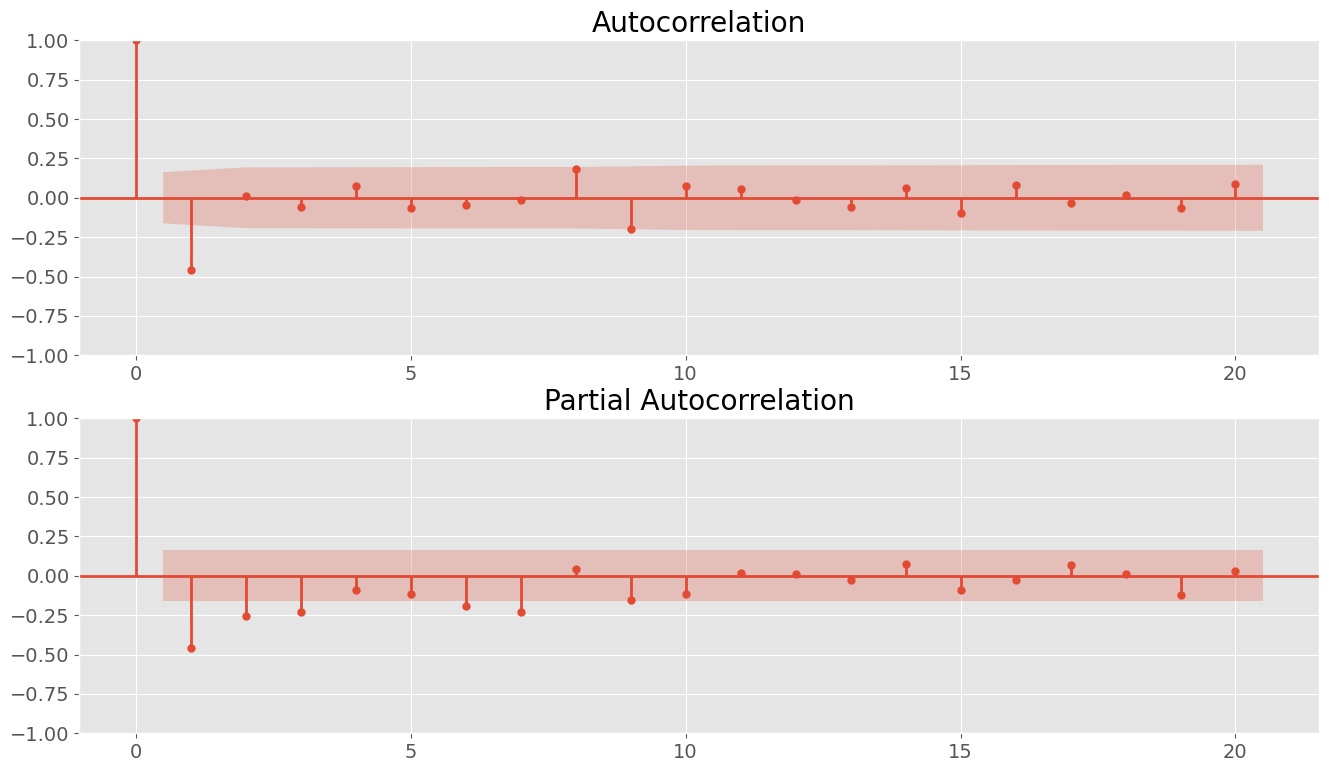

In [65]:
# Take first difference of the temperature Series
chg_temp = Climate.diff().dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)
# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])
# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show()

In [66]:
# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(chg_temp, order=(1, 0, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(chg_temp, order=(2, 0, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARIMA(chg_temp, order=(1,0,1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic,'\n')
print("The AIC of the ARMA(1,1) model is the lowest, so we should choose that model.")

The AIC for an AR(1) is:  510.5346898733107
The AIC for an AR(2) is:  501.9274123409138
The AIC for an ARMA(1,1) is:  469.07291850591673 

The AIC of the ARMA(1,1) model is the lowest, so we should choose that model.


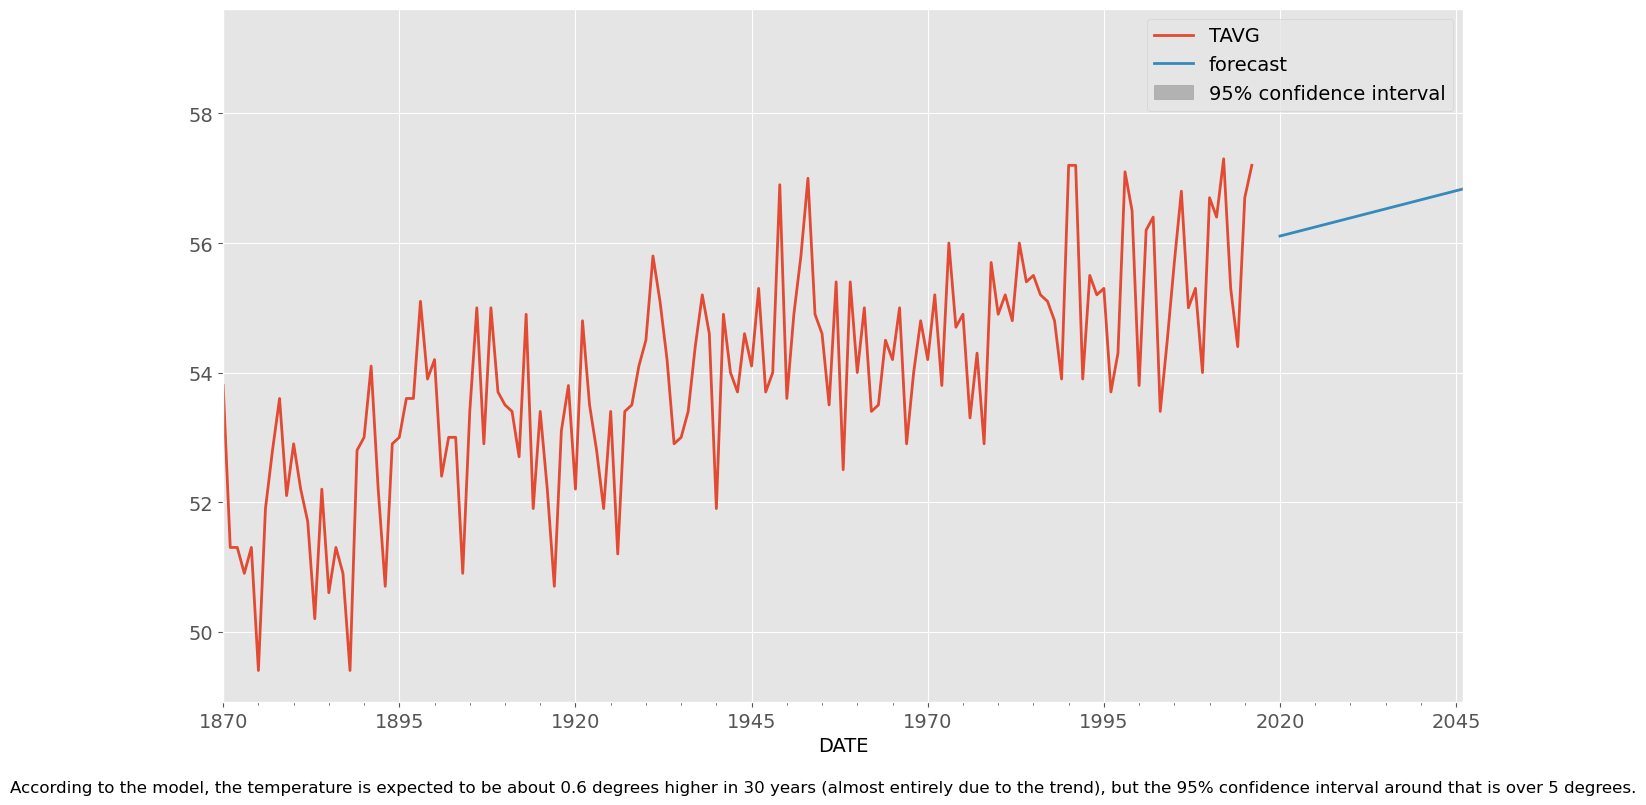

In [67]:
# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(Climate, trend='t', order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
fig, ax = plt.subplots()
Climate.plot(ax=ax)
plot_predict(res, start='2020', end='2046', ax=ax)
plt.figtext(0.5, 0.01, 'According to the model, the temperature is expected to be about 0.6 degrees higher in 30 years (almost entirely due to the trend), but the 95% confidence interval around that is over 5 degrees.', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()